# 模型介绍
Mask R-CNN通过添加一个与现有目标检测框回归并行的，用于预测目标掩码的分支来扩展Faster R-CNN，通过添加一个用于在每个感兴趣区域（RoI）上预测分割掩码的分支来扩展Faster R-CNN，就是在每个感兴趣区域（RoI）进行一个二分类的语义分割，在这个感兴趣区域同时做目标检测和分割，这个分支与用于分类和目标检测框回归的分支并行执行，如下图所示（用于目标分割的Mask R-CNN框架）：
![model](img/model.jpg)
掩码分支是作用于每个RoI的小FCN，以像素到像素的方式预测分割掩码，可是要在ROI区域进行一个mask分割，存在一个问题，Faster R-CNN不是为网络输入和输出之间的像素到像素对齐而设计的，如果直接拿Faster R-CNN得到的ROI进行mask分割，那么像素到像素的分割可能不精确，因为应用到目标检测上的核心操作执行的是粗略的空间量化特征提取，直接分割出来的mask存在错位的情况，所以作者提出了简单的，量化无关的层，称为RoIAlign(ROI对齐)，可以保留精确的空间位置，可以将掩码(mask)准确度提高10％至50％。
[论文:](http://cn.arxiv.org/pdf/1703.06870v3)"MaskRCNN"

## 模型结构
Mask R-CNN由两个阶段组成，称为区域提议网络（RPN）的第一阶段提出候选目标边界框。第二阶段本质上就是Fast R-CNN，它使用来自候选框架中的RoIPool来提取特征并进行分类和边界框回归，Mask R-CNN还为每个RoI输出二进制掩码。
![framework](img/framework.jpg)
模型整体结构组成为：骨干网络，特征金字塔网络(FPN)、区域提议网络以及Fast R-CNN。骨干网络和特征金字塔网络提取出图像的特征，然后区域提议网络在特征图上筛选出候选框，结合特征图和候选框后进行RoI Align，此后送入三个分支网络，分别获取分类结果、目标框以及目标区域的mask。

下图是以ResNet50为骨干网络加上FPN的网络结构：
![](img/resnet%2Bfpn.jpg)

此处推荐三个视频用于读者加深理解：[FPN](https://www.bilibili.com/video/BV1dh411U7D9?vd_source=2277cd0edf083354294094185f8857ab)、[Faster RCNN](https://www.bilibili.com/video/BV1af4y1m7iL?p=3&vd_source=2277cd0edf083354294094185f8857ab)、[Mask RCNN](https://www.bilibili.com/video/BV1ZY411774T?vd_source=2277cd0edf083354294094185f8857ab)。

## 模型优点
Mask R-CNN训练简单，只增加了Faster R-CNN少量的开销即可处理语义分割问题，运行速度为5fps。此外Mask R-CNN易于推广到其它任务中。

# 案例实现
## 环境准备与数据读取
本案例基于MindSpore-GPU版本实现，在GPU上完成模型训练。

案例实现所使用的数据为coco数据集，可从https://cocodataset.org/#download下载，需要下载对应的Image和Annotations。下载下来的Annotations的结构如图:
![](img/struct.jpg)
若需要调整训练所用的数据量，只需要调整image的选项即可。

**注意事项**：本案例需要安装pycocotools，若在windows上，使用``pip install pycocotools``安装会提示缺少c++库，可以使用``pip install pycocotools-windows``安装。在linux下安装时，可能会报缺少Cython的错误，先使用``pip install cython``安装好Cython即可。

## 数据集创建
接来下是创建数据集部分，首先需要将Annotations中的instances_(train/val)2017.json文件读入内存，然后根据images中的图片信息读取图片并解析mask信息然后将这些信息存入mindrecord文件(用于加速数据读取)。最后根据设定的batch size等信息创建MindDataset并组织数据成需要的形式，此过程会返回一个指向数据集的迭代器。至此完成数据集的创建，上述过程的代码对应如下：

In [ ]:
import numpy as np
from mindspore import context
import mindspore.nn as nn
from mindspore.ops import operations as P
from mindspore.common.tensor import Tensor
from mindspore.ops import functional as F
from mindspore.ops import composite as C
from mindspore.nn import layer as L
from mindspore.nn import Momentum
from mindspore.common.parameter import Parameter
from mindspore.common.initializer import initializer
import mindspore.common.dtype as mstype
import os
import time
from numpy import random
import cv2
from PIL import Image
import json
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from pycocotools.cocoeval import COCOeval
import mindspore.dataset as de
from mindspore.mindrecord import FileWriter
import mindspore.dataset.vision as vision
from mindspore import ParameterTuple
import mindspore.ops as ops
import mindspore as ms
import matplotlib.pyplot as plt
from mindspore.train import Model
from mindspore.train.callback import Callback
from mindspore.train.callback import CheckpointConfig, ModelCheckpoint, TimeMonitor
from mindspore.train.serialization import load_checkpoint, load_param_into_net
import matplotlib.pyplot as plt

np_cast_type = np.float32
time_stamp_init = time.time()
time_stamp_first = time.time()


def create_coco_label(is_training):
    """Get image path and annotation from COCO."""
    from pycocotools.coco import COCO

    coco_root = config.coco_root
    data_type = config.val_data_type
    if is_training:
        data_type = config.train_data_type

    # Classes need to train or test.
    train_cls = config.coco_classes

    train_cls_dict = {}
    for i, cls in enumerate(train_cls):
        train_cls_dict[cls] = i

    anno_json = os.path.join(coco_root, config.instance_set.format(data_type))

    coco = COCO(anno_json)
    classs_dict = {}
    cat_ids = coco.loadCats(coco.getCatIds())
    for cat in cat_ids:
        classs_dict[cat["id"]] = cat["name"]

    image_ids = coco.getImgIds()
    image_files = []
    image_anno_dict = {}
    masks = {}
    masks_shape = {}
    images_num = len(image_ids)
    for ind, img_id in enumerate(image_ids):
        image_info = coco.loadImgs(img_id)
        file_name = image_info[0]["file_name"]
        image_path = os.path.join(coco_root, data_type, file_name)
        if not os.path.isfile(image_path):
            print("{}/{}: {} is in annotations but not exist".format(ind + 1, images_num, image_path))
            continue
        anno_ids = coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anno = coco.loadAnns(anno_ids)
        image_path = os.path.join(coco_root, data_type, file_name)
        annos = []
        instance_masks = []
        image_height = coco.imgs[img_id]["height"]
        image_width = coco.imgs[img_id]["width"]
        if (ind + 1) % 10 == 0:
            print("{}/{}: parsing annotation for image={}".format(ind + 1, images_num, file_name))
        if not is_training:
            image_files.append(image_path)
            image_anno_dict[image_path] = np.array([0, 0, 0, 0, 0, 1])
            masks[image_path] = np.zeros([1, 1, 1], dtype=bool).tobytes()
            masks_shape[image_path] = np.array([1, 1, 1], dtype=np.int32)
        else:
            for label in anno:
                bbox = label["bbox"]
                class_name = classs_dict[label["category_id"]]
                if class_name in train_cls:
                    # get coco mask
                    m = annToMask(label, image_height, image_width)
                    if m.max() < 1:
                        print("all black mask!!!!")
                        continue
                    # Resize mask for the crowd
                    if label['iscrowd'] and (m.shape[0] != image_height or m.shape[1] != image_width):
                        m = np.ones([image_height, image_width], dtype=bool)
                    instance_masks.append(m)

                    # get coco bbox
                    x1, x2 = bbox[0], bbox[0] + bbox[2]
                    y1, y2 = bbox[1], bbox[1] + bbox[3]
                    annos.append([x1, y1, x2, y2] + [train_cls_dict[class_name]] + [int(label["iscrowd"])])
                else:
                    print("not in classes: ", class_name)

            image_files.append(image_path)
            if annos:
                image_anno_dict[image_path] = np.array(annos)
                instance_masks = np.stack(instance_masks, axis=0).astype(bool)
                masks[image_path] = np.array(instance_masks).tobytes()
                masks_shape[image_path] = np.array(instance_masks.shape, dtype=np.int32)
            else:
                print("no annotations for image ", file_name)
                image_anno_dict[image_path] = np.array([0, 0, 0, 0, 0, 1])
                masks[image_path] = np.zeros([1, image_height, image_width], dtype=bool).tobytes()
                masks_shape[image_path] = np.array([1, image_height, image_width], dtype=np.int32)

    return image_files, image_anno_dict, masks, masks_shape


def data_to_mindrecord_byte_image(dataset="coco", is_training=True, prefix="maskrcnn.mindrecord", file_num=8):
    """Create MindRecord file."""
    mindrecord_dir = config.mindrecord_dir
    mindrecord_path = os.path.join(mindrecord_dir, prefix)

    writer = FileWriter(mindrecord_path, file_num)
    if dataset == "coco":
        image_files, image_anno_dict, masks, masks_shape = create_coco_label(is_training)
    else:
        print("Error unsupported other dataset")
        return

    maskrcnn_json = {
        "image": {"type": "bytes"},
        "annotation": {"type": "int32", "shape": [-1, 6]},
        "mask": {"type": "bytes"},
        "mask_shape": {"type": "int32", "shape": [-1]},
    }
    writer.add_schema(maskrcnn_json, "maskrcnn_json")

    image_files_num = len(image_files)
    for ind, image_name in enumerate(image_files):
        with open(image_name, 'rb') as f:
            img = f.read()
        annos = np.array(image_anno_dict[image_name], dtype=np.int32)
        mask = masks[image_name]
        mask_shape = masks_shape[image_name]
        row = {"image": img, "annotation": annos, "mask": mask, "mask_shape": mask_shape}
        if (ind + 1) % 10 == 0:
            print("writing {}/{} into mindrecord".format(ind + 1, image_files_num))
        writer.write_raw_data([row])
    writer.commit()


def create_maskrcnn_dataset(mindrecord_file, batch_size=2, device_num=1, rank_id=0,
                            is_training=True, num_parallel_workers=2):
    """Create MaskRcnn dataset with MindDataset."""
    cv2.setNumThreads(0)
    de.config.set_prefetch_size(8)
    ds = de.MindDataset(mindrecord_file, columns_list=["image", "annotation", "mask", "mask_shape"],
                        num_shards=device_num, shard_id=rank_id,
                        num_parallel_workers=4, shuffle=is_training)

    decode = vision.Decode()
    ds = ds.map(operations=decode, input_columns=["image"])
    compose_map_func = (lambda image, annotation, mask, mask_shape:
                        preprocess_fn(image, annotation, mask, mask_shape, is_training))

    if is_training:
        ds = ds.map(operations=compose_map_func,
                    input_columns=["image", "annotation", "mask", "mask_shape"],
                    output_columns=["image", "image_shape", "box", "label", "valid_num", "mask"],
                    column_order=["image", "image_shape", "box", "label", "valid_num", "mask"],
                    python_multiprocessing=False,
                    num_parallel_workers=num_parallel_workers)
        ds = ds.batch(batch_size, drop_remainder=True, pad_info={"mask": ([config.max_instance_count, None, None], 0)})

    else:
        ds = ds.map(operations=compose_map_func,
                    input_columns=["image", "annotation", "mask", "mask_shape"],
                    output_columns=["image", "image_shape", "box", "label", "valid_num", "mask"],
                    column_order=["image", "image_shape", "box", "label", "valid_num", "mask"],
                    num_parallel_workers=num_parallel_workers)
        ds = ds.batch(batch_size, drop_remainder=True)

    return ds


def create_mindrecord_dir(prefix, mindrecord_dir, mindrecord_file):
    if not os.path.isdir(mindrecord_dir):
        os.makedirs(mindrecord_dir)
    if os.path.isdir('val2017'):
        print("Create Mindrecord.")
        data_to_mindrecord_byte_image("coco", True, prefix)
        print("Create Mindrecord Done, at {}".format(mindrecord_dir))
    else:
        raise Exception("coco_root not exits.")
    while not os.path.exists(mindrecord_file + ".db"):
        time.sleep(5)

## 模型构建
本案例实现的Mask R-CNN结构和论文中的结构大体相同，骨干网络采用的是ResNet50。具体的网络结构，读者根据模型结构介绍中的图片以及论文原文中提供的mask分支结构可以有个清晰的认知，此处就不放具体的网络结构图了。

在具体的实现上，MindSpore和pytorch差异不大，只是一些方法名上的替换，具体的API映射可见https://www.mindspore.cn/docs/zh-CN/r1.8/note/api_mapping/pytorch_api_mapping.html#torch-nn。

loading annotations into memory...
Done (t=1.22s)
creating index...
index created!


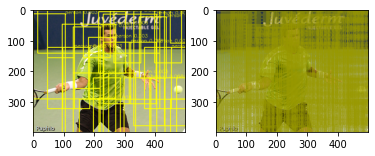

In [1]:
class ResNet(nn.Cell):
    """
    ResNet architecture.

    Args:
        block (Cell): Block for network.
        layer_nums (list): Numbers of block in different layers.
        in_channels (list): Input channel in each layer.
        out_channels (list): Output channel in each layer.
        weights_update (bool): Weight update flag.
    Returns:
        Tensor, output tensor.

    Examples:
        >>> ResNet(ResidualBlock,
        >>>        [3, 4, 6, 3],
        >>>        [64, 256, 512, 1024],
        >>>        [256, 512, 1024, 2048],
        >>>        False)
    """

    def __init__(self,
                 block,
                 layer_nums,
                 in_channels,
                 out_channels,
                 weights_update=False):
        super(ResNet, self).__init__()

        if not len(layer_nums) == len(in_channels) == len(out_channels) == 4:
            raise ValueError("the length of "
                             "layer_num, inchannel, outchannel list must be 4!")

        bn_training = False
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, pad_mode='pad')
        self.bn1 = nn.BatchNorm2d(64, affine=bn_training, use_batch_statistics=bn_training)
        self.relu = P.ReLU()
        self.maxpool = P.MaxPool(kernel_size=3, strides=2, pad_mode="SAME")
        self.weights_update = weights_update

        if not self.weights_update:
            self.conv1.weight.requires_grad = False

        self.layer1 = self._make_layer(block,
                                       layer_nums[0],
                                       in_channel=in_channels[0],
                                       out_channel=out_channels[0],
                                       stride=1,
                                       training=bn_training,
                                       weights_update=self.weights_update)
        self.layer2 = self._make_layer(block,
                                       layer_nums[1],
                                       in_channel=in_channels[1],
                                       out_channel=out_channels[1],
                                       stride=2,
                                       training=bn_training,
                                       weights_update=True)
        self.layer3 = self._make_layer(block,
                                       layer_nums[2],
                                       in_channel=in_channels[2],
                                       out_channel=out_channels[2],
                                       stride=2,
                                       training=bn_training,
                                       weights_update=True)
        self.layer4 = self._make_layer(block,
                                       layer_nums[3],
                                       in_channel=in_channels[3],
                                       out_channel=out_channels[3],
                                       stride=2,
                                       training=bn_training,
                                       weights_update=True)

    def _make_layer(self, block, layer_num, in_channel, out_channel, stride, training=False, weights_update=False):
        """Make block layer."""
        layers = []
        down_sample = False
        if stride != 1 or in_channel != out_channel:
            down_sample = True
        resblk = block(in_channel,
                       out_channel,
                       stride=stride,
                       down_sample=down_sample,
                       training=training,
                       weights_update=weights_update)
        layers.append(resblk)

        for _ in range(1, layer_num):
            resblk = block(out_channel, out_channel, stride=1, training=training, weights_update=weights_update)
            layers.append(resblk)

        return nn.SequentialCell(layers)

    def construct(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        c1 = self.maxpool(x)

        c2 = self.layer1(c1)
        identity = c2
        if not self.weights_update:
            identity = F.stop_gradient(c2)
        c3 = self.layer2(identity)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        return identity, c3, c4, c5


class ResidualBlock(nn.Cell):
    """
    ResNet V1 residual block definition.

    Args:
        in_channels (int) - Input channel.
        out_channels (int) - Output channel.
        stride (int) - Stride size for the initial convolutional layer. Default: 1.
        down_sample (bool) - If to do the downsample in block. Default: False.
        momentum (float) - Momentum for batchnorm layer. Default: 0.1.
        training (bool) - Training flag. Default: False.
        weights_updata (bool) - Weights update flag. Default: False.

    Returns:
        Tensor, output tensor.

    Examples:
        ResidualBlock(3,256,stride=2,down_sample=True)
    """
    expansion = 4

    def __init__(self,
                 in_channels,
                 out_channels,
                 stride=1,
                 down_sample=False,
                 momentum=0.1,
                 training=False,
                 weights_update=False):
        super(ResidualBlock, self).__init__()

        self.affine = weights_update

        out_chls = out_channels // self.expansion
        self.conv1 = nn.Conv2d(in_channels, out_chls, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_chls, momentum=momentum, affine=self.affine, use_batch_statistics=training)

        self.conv2 = nn.Conv2d(out_chls, out_chls, kernel_size=3, stride=stride, pad_mode='pad', padding=1)
        self.bn2 = nn.BatchNorm2d(out_chls, momentum=momentum, affine=self.affine, use_batch_statistics=training)

        self.conv3 = nn.Conv2d(out_chls, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels, momentum=momentum, affine=self.affine, use_batch_statistics=training)

        if training:
            self.bn1 = self.bn1.set_train()
            self.bn2 = self.bn2.set_train()
            self.bn3 = self.bn3.set_train()

        if not weights_update:
            self.conv1.weight.requires_grad = False
            self.conv2.weight.requires_grad = False
            self.conv3.weight.requires_grad = False

        self.relu = P.ReLU()
        self.downsample = down_sample
        if self.downsample:
            self.conv_down_sample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0)
            self.bn_down_sample = nn.BatchNorm2d(out_channels, momentum=momentum, affine=self.affine,
                                                 use_batch_statistics=training)
            if training:
                self.bn_down_sample = self.bn_down_sample.set_train()
            if not weights_update:
                self.conv_down_sample.weight.requires_grad = False
        self.add = P.Add()

    def construct(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample:
            identity = self.conv_down_sample(identity)
            identity = self.bn_down_sample(identity)

        out = self.add(out, identity)
        out = self.relu(out)

        return out


class FeatPyramidNeck(nn.Cell):
    """
    Feature pyramid network cell, usually uses as network neck.

    Applies the convolution on multiple, input feature maps
    and output feature map with same channel size. if required num of
    output larger then num of inputs, add extra maxpooling for further
    downsampling;

    Args:
        in_channels (tuple) - Channel size of input feature maps.
        out_channels (int) - Channel size output.
        num_outs (int) - Num of output features.

    Returns:
        Tuple, with tensors of same channel size.

    Examples:
        neck = FeatPyramidNeck([100,200,300], 50, 4, config.feature_shapes)
        input_data = (normal(0,0.1,(1,c,1280//(4*2**i), 768//(4*2**i)),
                      dtype=np.float32) \
                      for i, c in enumerate(config.fpn_in_channels))
        x = neck(input_data)
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 num_outs,
                 feature_shapes):
        super(FeatPyramidNeck, self).__init__()

        if context.get_context("device_target") == "Ascend":
            self.cast_type = mstype.float32
        else:
            self.cast_type = mstype.float32

        self.num_outs = num_outs
        self.in_channels = in_channels
        self.fpn_layer = len(self.in_channels)

        assert not self.num_outs < len(in_channels)

        self.lateral_convs_list_ = []
        self.fpn_convs_ = []

        for _, channel in enumerate(in_channels):
            l_conv = nn.Conv2d(channel, out_channels, kernel_size=1, stride=1,
                               padding=0, pad_mode='valid').to_float(self.cast_type)
            fpn_conv = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                                 padding=0, pad_mode='same').to_float(self.cast_type)
            self.lateral_convs_list_.append(l_conv)
            self.fpn_convs_.append(fpn_conv)
        self.lateral_convs_list = nn.layer.CellList(self.lateral_convs_list_)
        self.fpn_convs_list = nn.layer.CellList(self.fpn_convs_)
        self.interpolate1 = P.ResizeBilinear(feature_shapes[2])
        self.interpolate2 = P.ResizeBilinear(feature_shapes[1])
        self.interpolate3 = P.ResizeBilinear(feature_shapes[0])
        self.cast = P.Cast()
        self.maxpool = P.MaxPool(kernel_size=1, strides=2, pad_mode="same")

    def construct(self, inputs):
        x = ()
        for i in range(self.fpn_layer):
            x += (self.lateral_convs_list[i](inputs[i]),)

        y = (x[3],)
        y = y + (x[2] + self.cast(self.interpolate1(y[self.fpn_layer - 4]), self.cast_type),)
        y = y + (x[1] + self.cast(self.interpolate2(y[self.fpn_layer - 3]), self.cast_type),)
        y = y + (x[0] + self.cast(self.interpolate3(y[self.fpn_layer - 2]), self.cast_type),)

        z = ()
        for i in range(self.fpn_layer - 1, -1, -1):
            z = z + (y[i],)

        outs = ()
        for i in range(self.fpn_layer):
            outs = outs + (self.fpn_convs_list[i](z[i]),)

        for i in range(self.num_outs - self.fpn_layer):
            outs = outs + (self.maxpool(outs[3]),)
        return outs


class BboxAssignSample(nn.Cell):
    """
    Bbox assigner and sampler definition.

    Args:
        config (dict): Config.
        batch_size (int): Batchsize.
        num_bboxes (int): The anchor nums.
        add_gt_as_proposals (bool): add gt bboxes as proposals flag.

    Returns:
        Tensor, output tensor.
        bbox_targets: bbox location, (batch_size, num_bboxes, 4)
        bbox_weights: bbox weights, (batch_size, num_bboxes, 1)
        labels: label for every bboxes, (batch_size, num_bboxes, 1)
        label_weights: label weight for every bboxes, (batch_size, num_bboxes, 1)

    Examples:
        BboxAssignSample(config, 2, 1024, True)
    """

    def __init__(self, config, batch_size, num_bboxes, add_gt_as_proposals):
        super(BboxAssignSample, self).__init__()
        cfg = config

        if context.get_context("device_target") == "Ascend":
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32
        else:
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32

        self.batch_size = batch_size

        self.neg_iou_thr = Tensor(cfg.neg_iou_thr, self.cast_type)
        self.pos_iou_thr = Tensor(cfg.pos_iou_thr, self.cast_type)
        self.min_pos_iou = Tensor(cfg.min_pos_iou, self.cast_type)
        self.zero_thr = Tensor(0.0, self.cast_type)

        self.num_bboxes = num_bboxes
        self.num_gts = cfg.num_gts
        self.num_expected_pos = cfg.num_expected_pos
        self.num_expected_neg = cfg.num_expected_neg
        self.add_gt_as_proposals = add_gt_as_proposals

        if self.add_gt_as_proposals:
            self.label_inds = Tensor(np.arange(1, self.num_gts + 1))

        self.concat = P.Concat(axis=0)
        self.max_gt = P.ArgMaxWithValue(axis=0)
        self.max_anchor = P.ArgMaxWithValue(axis=1)
        self.sum_inds = P.ReduceSum()
        self.iou = P.IOU()
        self.greaterequal = P.GreaterEqual()
        self.greater = P.Greater()
        self.select = P.Select()
        self.gatherND = P.GatherNd()
        self.squeeze = P.Squeeze()
        self.cast = P.Cast()
        self.logicaland = P.LogicalAnd()
        self.less = P.Less()
        self.random_choice_with_mask_pos = P.RandomChoiceWithMask(self.num_expected_pos)
        self.random_choice_with_mask_neg = P.RandomChoiceWithMask(self.num_expected_neg)
        self.reshape = P.Reshape()
        self.equal = P.Equal()
        self.bounding_box_encode = P.BoundingBoxEncode(means=(0.0, 0.0, 0.0, 0.0), stds=(1.0, 1.0, 1.0, 1.0))
        self.scatterNdUpdate = P.ScatterNdUpdate()
        self.scatterNd = P.ScatterNd()
        self.logicalnot = P.LogicalNot()
        self.tile = P.Tile()
        self.zeros_like = P.ZerosLike()

        self.assigned_gt_inds = Tensor(np.array(-1 * np.ones(num_bboxes), dtype=np.int32))
        self.assigned_gt_zeros = Tensor(np.array(np.zeros(num_bboxes), dtype=np.int32))
        self.assigned_gt_ones = Tensor(np.array(np.ones(num_bboxes), dtype=np.int32))
        self.assigned_gt_ignores = Tensor(np.array(-1 * np.ones(num_bboxes), dtype=np.int32))
        self.assigned_pos_ones = Tensor(np.array(np.ones(self.num_expected_pos), dtype=np.int32))

        self.check_neg_mask = Tensor(np.array(np.ones(self.num_expected_neg - self.num_expected_pos), dtype=bool))
        self.range_pos_size = Tensor(np.arange(self.num_expected_pos).astype(self.np_cast_type))
        self.check_gt_one = Tensor(np.array(-1 * np.ones((self.num_gts, 4)), dtype=self.np_cast_type))
        self.check_anchor_two = Tensor(np.array(-2 * np.ones((self.num_bboxes, 4)), dtype=self.np_cast_type))

    def construct(self, gt_bboxes_i, gt_labels_i, valid_mask, bboxes, gt_valids):
        gt_bboxes_i = self.select(self.cast(self.tile(self.reshape(self.cast(gt_valids, mstype.int32), \
                                                                   (self.num_gts, 1)), (1, 4)), mstype.bool_),
                                  gt_bboxes_i, self.check_gt_one)
        bboxes = self.select(self.cast(self.tile(self.reshape(self.cast(valid_mask, mstype.int32), \
                                                              (self.num_bboxes, 1)), (1, 4)), mstype.bool_), bboxes,
                             self.check_anchor_two)

        overlaps = self.iou(bboxes, gt_bboxes_i)

        max_overlaps_w_gt_index, max_overlaps_w_gt = self.max_gt(overlaps)
        _, max_overlaps_w_ac = self.max_anchor(overlaps)

        neg_sample_iou_mask = self.logicaland(self.greaterequal(max_overlaps_w_gt, self.zero_thr), \
                                              self.less(max_overlaps_w_gt, self.neg_iou_thr))
        assigned_gt_inds2 = self.select(neg_sample_iou_mask, self.assigned_gt_zeros, self.assigned_gt_inds)

        pos_sample_iou_mask = self.greaterequal(max_overlaps_w_gt, self.pos_iou_thr)
        assigned_gt_inds3 = self.select(pos_sample_iou_mask, \
                                        max_overlaps_w_gt_index + self.assigned_gt_ones, assigned_gt_inds2)
        assigned_gt_inds4 = assigned_gt_inds3
        for j in range(self.num_gts):
            max_overlaps_w_ac_j = max_overlaps_w_ac[j:j + 1:1]
            overlaps_w_gt_j = self.squeeze(overlaps[j:j + 1:1, ::])

            pos_mask_j = self.logicaland(self.greaterequal(max_overlaps_w_ac_j, self.min_pos_iou), \
                                         self.equal(overlaps_w_gt_j, max_overlaps_w_ac_j))

            assigned_gt_inds4 = self.select(pos_mask_j, self.assigned_gt_ones + j, assigned_gt_inds4)

        assigned_gt_inds5 = self.select(valid_mask, assigned_gt_inds4, self.assigned_gt_ignores)

        pos_index, valid_pos_index = self.random_choice_with_mask_pos(self.greater(assigned_gt_inds5, 0))

        pos_check_valid = self.cast(self.greater(assigned_gt_inds5, 0), self.cast_type)
        pos_check_valid = self.sum_inds(pos_check_valid, -1)
        valid_pos_index = self.less(self.range_pos_size, pos_check_valid)
        pos_index = pos_index * self.reshape(self.cast(valid_pos_index, mstype.int32), (self.num_expected_pos, 1))

        pos_assigned_gt_index = self.gatherND(assigned_gt_inds5, pos_index) - self.assigned_pos_ones
        pos_assigned_gt_index = pos_assigned_gt_index * self.cast(valid_pos_index, mstype.int32)
        pos_assigned_gt_index = self.reshape(pos_assigned_gt_index, (self.num_expected_pos, 1))

        neg_index, valid_neg_index = self.random_choice_with_mask_neg(self.equal(assigned_gt_inds5, 0))

        num_pos = self.cast(self.logicalnot(valid_pos_index), self.cast_type)
        num_pos = self.sum_inds(num_pos, -1)
        unvalid_pos_index = self.less(self.range_pos_size, num_pos)
        valid_neg_index = self.logicaland(self.concat((self.check_neg_mask, unvalid_pos_index)), valid_neg_index)

        pos_bboxes_ = self.gatherND(bboxes, pos_index)
        pos_gt_bboxes_ = self.gatherND(gt_bboxes_i, pos_assigned_gt_index)
        pos_gt_labels = self.gatherND(gt_labels_i, pos_assigned_gt_index)

        pos_bbox_targets_ = self.bounding_box_encode(pos_bboxes_, pos_gt_bboxes_)

        valid_pos_index = self.cast(valid_pos_index, mstype.int32)
        valid_neg_index = self.cast(valid_neg_index, mstype.int32)
        bbox_targets_total = self.scatterNd(pos_index, pos_bbox_targets_, (self.num_bboxes, 4))
        bbox_weights_total = self.scatterNd(pos_index, valid_pos_index, (self.num_bboxes,))
        labels_total = self.scatterNd(pos_index, pos_gt_labels, (self.num_bboxes,))
        total_index = self.concat((pos_index, neg_index))
        total_valid_index = self.concat((valid_pos_index, valid_neg_index))
        label_weights_total = self.scatterNd(total_index, total_valid_index, (self.num_bboxes,))

        return bbox_targets_total, self.cast(bbox_weights_total, mstype.bool_), \
               labels_total, self.cast(label_weights_total, mstype.bool_)


class RpnRegClsBlock(nn.Cell):
    """
    Rpn reg cls block for rpn layer

    Args:
        in_channels (int) - Input channels of shared convolution.
        feat_channels (int) - Output channels of shared convolution.
        num_anchors (int) - The anchor number.
        cls_out_channels (int) - Output channels of classification convolution.
        weight_conv (Tensor) - weight init for rpn conv.
        bias_conv (Tensor) - bias init for rpn conv.
        weight_cls (Tensor) - weight init for rpn cls conv.
        bias_cls (Tensor) - bias init for rpn cls conv.
        weight_reg (Tensor) - weight init for rpn reg conv.
        bias_reg (Tensor) - bias init for rpn reg conv.

    Returns:
        Tensor, output tensor.
    """

    def __init__(self,
                 in_channels,
                 feat_channels,
                 num_anchors,
                 cls_out_channels,
                 weight_conv,
                 bias_conv,
                 weight_cls,
                 bias_cls,
                 weight_reg,
                 bias_reg):
        super(RpnRegClsBlock, self).__init__()
        self.rpn_conv = nn.Conv2d(in_channels, feat_channels, kernel_size=3, stride=1, pad_mode='same',
                                  has_bias=True, weight_init=weight_conv, bias_init=bias_conv)
        self.relu = nn.ReLU()

        self.rpn_cls = nn.Conv2d(feat_channels, num_anchors * cls_out_channels, kernel_size=1, pad_mode='valid',
                                 has_bias=True, weight_init=weight_cls, bias_init=bias_cls)
        self.rpn_reg = nn.Conv2d(feat_channels, num_anchors * 4, kernel_size=1, pad_mode='valid',
                                 has_bias=True, weight_init=weight_reg, bias_init=bias_reg)

    def construct(self, x):
        x = self.relu(self.rpn_conv(x))

        x1 = self.rpn_cls(x)
        x2 = self.rpn_reg(x)

        return x1, x2


class RPN(nn.Cell):
    """
    ROI proposal network..

    Args:
        config (dict) - Config.
        batch_size (int) - Batchsize.
        in_channels (int) - Input channels of shared convolution.
        feat_channels (int) - Output channels of shared convolution.
        num_anchors (int) - The anchor number.
        cls_out_channels (int) - Output channels of classification convolution.

    Returns:
        Tuple, tuple of output tensor.

    Examples:
        RPN(config=config, batch_size=2, in_channels=256, feat_channels=1024,
            num_anchors=3, cls_out_channels=512)
    """
    def __init__(self,
                 config,
                 batch_size,
                 in_channels,
                 feat_channels,
                 num_anchors,
                 cls_out_channels):
        super(RPN, self).__init__()
        cfg_rpn = config
        if context.get_context("device_target") == "CPU" or context.get_context("device_target") == "GPU":
            self.platform_dtype = np.float32
            self.platform_mstype = mstype.float32
        else:
            self.platform_dtype = np.float32
            self.platform_mstype = mstype.float32
        self.num_bboxes = cfg_rpn.num_bboxes
        self.slice_index = ()
        self.feature_anchor_shape = ()
        self.slice_index += (0,)
        index = 0
        for shape in cfg_rpn.feature_shapes:
            self.slice_index += (self.slice_index[index] + shape[0] * shape[1] * num_anchors,)
            self.feature_anchor_shape += (shape[0] * shape[1] * num_anchors * batch_size,)
            index += 1

        self.num_anchors = num_anchors
        self.batch_size = batch_size
        self.test_batch_size = cfg_rpn.test_batch_size
        self.num_layers = 5
        self.real_ratio = Tensor(np.ones((1, 1)).astype(self.platform_dtype))

        self.rpn_convs_list = nn.layer.CellList(self._make_rpn_layer(self.num_layers, in_channels, feat_channels,
                                                                     num_anchors, cls_out_channels))

        self.transpose = P.Transpose()
        self.reshape = P.Reshape()
        self.concat = P.Concat(axis=0)
        self.fill = P.Fill()
        self.placeh1 = Tensor(np.ones((1,)).astype(self.platform_dtype))

        self.trans_shape = (0, 2, 3, 1)

        self.reshape_shape_reg = (-1, 4)
        self.reshape_shape_cls = (-1,)
        self.rpn_loss_reg_weight = Tensor(np.array(cfg_rpn.rpn_loss_reg_weight).astype(self.platform_dtype))
        self.rpn_loss_cls_weight = Tensor(np.array(cfg_rpn.rpn_loss_cls_weight).astype(self.platform_dtype))
        self.num_expected_total = Tensor(np.array(cfg_rpn.num_expected_neg * \
                                                  self.batch_size).astype(self.platform_dtype))
        self.num_bboxes = cfg_rpn.num_bboxes
        self.get_targets = BboxAssignSample(cfg_rpn, self.batch_size, self.num_bboxes, False)
        self.CheckValid = P.CheckValid()
        self.sum_loss = P.ReduceSum()
        self.loss_cls = P.SigmoidCrossEntropyWithLogits()
        self.loss_bbox = P.SmoothL1Loss(beta=1.0/9.0)
        self.squeeze = P.Squeeze()
        self.cast = P.Cast()
        self.tile = P.Tile()
        self.zeros_like = P.ZerosLike()
        self.loss = Tensor(np.zeros((1,)).astype(self.platform_dtype))
        self.clsloss = Tensor(np.zeros((1,)).astype(self.platform_dtype))
        self.regloss = Tensor(np.zeros((1,)).astype(self.platform_dtype))

    def _make_rpn_layer(self, num_layers, in_channels, feat_channels, num_anchors, cls_out_channels):
        """
        make rpn layer for rpn proposal network

        Args:
        num_layers (int) - layer num.
        in_channels (int) - Input channels of shared convolution.
        feat_channels (int) - Output channels of shared convolution.
        num_anchors (int) - The anchor number.
        cls_out_channels (int) - Output channels of classification convolution.

        Returns:
        List, list of RpnRegClsBlock cells.
        """
        rpn_layer = []

        shp_weight_conv = (feat_channels, in_channels, 3, 3)
        shp_bias_conv = (feat_channels,)
        weight_conv = initializer('Normal', shape=shp_weight_conv, dtype=mstype.float32)
        bias_conv = initializer(0, shape=shp_bias_conv, dtype=mstype.float32)

        shp_weight_cls = (num_anchors * cls_out_channels, feat_channels, 1, 1)
        shp_bias_cls = (num_anchors * cls_out_channels,)
        weight_cls = initializer('Normal', shape=shp_weight_cls, dtype=mstype.float32)
        bias_cls = initializer(0, shape=shp_bias_cls, dtype=mstype.float32)

        shp_weight_reg = (num_anchors * 4, feat_channels, 1, 1)
        shp_bias_reg = (num_anchors * 4,)
        weight_reg = initializer('Normal', shape=shp_weight_reg, dtype=mstype.float32)
        bias_reg = initializer(0, shape=shp_bias_reg, dtype=mstype.float32)

        for i in range(num_layers):
            rpn_layer.append(RpnRegClsBlock(in_channels, feat_channels, num_anchors, cls_out_channels, \
                                            weight_conv, bias_conv, weight_cls, \
                                            bias_cls, weight_reg, bias_reg).to_float(self.platform_mstype))

        for i in range(1, num_layers):
            rpn_layer[i].rpn_conv.weight = rpn_layer[0].rpn_conv.weight
            rpn_layer[i].rpn_cls.weight = rpn_layer[0].rpn_cls.weight
            rpn_layer[i].rpn_reg.weight = rpn_layer[0].rpn_reg.weight

            rpn_layer[i].rpn_conv.bias = rpn_layer[0].rpn_conv.bias
            rpn_layer[i].rpn_cls.bias = rpn_layer[0].rpn_cls.bias
            rpn_layer[i].rpn_reg.bias = rpn_layer[0].rpn_reg.bias

        return rpn_layer

    def construct(self, inputs, img_metas, anchor_list, gt_bboxes, gt_labels, gt_valids):
        loss_print = ()
        rpn_cls_score = ()
        rpn_bbox_pred = ()
        rpn_cls_score_total = ()
        rpn_bbox_pred_total = ()

        for i in range(self.num_layers):
            x1, x2 = self.rpn_convs_list[i](inputs[i])

            rpn_cls_score_total = rpn_cls_score_total + (x1,)
            rpn_bbox_pred_total = rpn_bbox_pred_total + (x2,)

            x1 = self.transpose(x1, self.trans_shape)
            x1 = self.reshape(x1, self.reshape_shape_cls)

            x2 = self.transpose(x2, self.trans_shape)
            x2 = self.reshape(x2, self.reshape_shape_reg)

            rpn_cls_score = rpn_cls_score + (x1,)
            rpn_bbox_pred = rpn_bbox_pred + (x2,)

        loss = self.loss
        clsloss = self.clsloss
        regloss = self.regloss
        bbox_targets = ()
        bbox_weights = ()
        labels = ()
        label_weights = ()

        output = ()
        if self.training:
            for i in range(self.batch_size):
                multi_level_flags = ()
                anchor_list_tuple = ()

                for j in range(self.num_layers):
                    res = self.cast(self.CheckValid(anchor_list[j], self.squeeze(img_metas[i:i + 1, ::])),
                                    mstype.int32)
                    multi_level_flags = multi_level_flags + (res,)
                    anchor_list_tuple = anchor_list_tuple + (anchor_list[j],)

                valid_flag_list = self.concat(multi_level_flags)
                anchor_using_list = self.concat(anchor_list_tuple)

                gt_bboxes_i = self.squeeze(gt_bboxes[i:i + 1:1, ::])
                gt_labels_i = self.squeeze(gt_labels[i:i + 1:1, ::])
                gt_valids_i = self.squeeze(gt_valids[i:i + 1:1, ::])

                bbox_target, bbox_weight, label, label_weight = self.get_targets(gt_bboxes_i,
                                                                                 gt_labels_i,
                                                                                 self.cast(valid_flag_list,
                                                                                           mstype.bool_),
                                                                                 anchor_using_list, gt_valids_i)

                bbox_weight = self.cast(bbox_weight, self.platform_mstype)
                label = self.cast(label, self.platform_mstype)
                label_weight = self.cast(label_weight, self.platform_mstype)

                for j in range(self.num_layers):
                    begin = self.slice_index[j]
                    end = self.slice_index[j + 1]
                    stride = 1
                    bbox_targets += (bbox_target[begin:end:stride, ::],)
                    bbox_weights += (bbox_weight[begin:end:stride],)
                    labels += (label[begin:end:stride],)
                    label_weights += (label_weight[begin:end:stride],)

            for i in range(self.num_layers):
                bbox_target_using = ()
                bbox_weight_using = ()
                label_using = ()
                label_weight_using = ()

                for j in range(self.batch_size):
                    bbox_target_using += (bbox_targets[i + (self.num_layers * j)],)
                    bbox_weight_using += (bbox_weights[i + (self.num_layers * j)],)
                    label_using += (labels[i + (self.num_layers * j)],)
                    label_weight_using += (label_weights[i + (self.num_layers * j)],)

                bbox_target_with_batchsize = self.concat(bbox_target_using)
                bbox_weight_with_batchsize = self.concat(bbox_weight_using)
                label_with_batchsize = self.concat(label_using)
                label_weight_with_batchsize = self.concat(label_weight_using)

                # stop
                bbox_target_ = F.stop_gradient(bbox_target_with_batchsize)
                bbox_weight_ = F.stop_gradient(bbox_weight_with_batchsize)
                label_ = F.stop_gradient(label_with_batchsize)
                label_weight_ = F.stop_gradient(label_weight_with_batchsize)

                cls_score_i = rpn_cls_score[i]
                reg_score_i = rpn_bbox_pred[i]

                loss_cls = self.loss_cls(cls_score_i, label_)
                loss_cls_item = loss_cls * label_weight_
                loss_cls_item = self.sum_loss(loss_cls_item, (0,)) / self.num_expected_total

                loss_reg = self.loss_bbox(reg_score_i, bbox_target_)
                bbox_weight_ = self.tile(self.reshape(bbox_weight_, (self.feature_anchor_shape[i], 1)), (1, 4))
                loss_reg = loss_reg * bbox_weight_
                loss_reg_item = self.sum_loss(loss_reg, (1,))
                loss_reg_item = self.sum_loss(loss_reg_item, (0,)) / self.num_expected_total

                loss_total = self.rpn_loss_cls_weight * loss_cls_item + self.rpn_loss_reg_weight * loss_reg_item

                loss += loss_total
                loss_print += (loss_total, loss_cls_item, loss_reg_item)
                clsloss += loss_cls_item
                regloss += loss_reg_item

                output = (loss, rpn_cls_score_total, rpn_bbox_pred_total, clsloss, regloss, loss_print)
        else:
            output = (self.placeh1, rpn_cls_score_total, rpn_bbox_pred_total, self.placeh1, self.placeh1, self.placeh1)

        return output


class Proposal(nn.Cell):
    """
    Proposal subnet.

    Args:
        config (dict): Config.
        batch_size (int): Batchsize.
        num_classes (int) - Class number.
        use_sigmoid_cls (bool) - Select sigmoid or softmax function.
        target_means (tuple) - Means for encode function. Default: (.0, .0, .0, .0).
        target_stds (tuple) - Stds for encode function. Default: (1.0, 1.0, 1.0, 1.0).

    Returns:
        Tuple, tuple of output tensor,(proposal, mask).

    Examples:
        Proposal(config = config, batch_size = 1, num_classes = 81, use_sigmoid_cls = True, \
                 target_means=(.0, .0, .0, .0), target_stds=(1.0, 1.0, 1.0, 1.0))
    """

    def __init__(self,
                 config,
                 batch_size,
                 num_classes,
                 use_sigmoid_cls,
                 target_means=(.0, .0, .0, .0),
                 target_stds=(1.0, 1.0, 1.0, 1.0)
                 ):
        super(Proposal, self).__init__()
        cfg = config

        if context.get_context("device_target") == "Ascend":
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32
        else:
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32

        self.batch_size = batch_size
        self.num_classes = num_classes
        self.target_means = target_means
        self.target_stds = target_stds
        self.use_sigmoid_cls = use_sigmoid_cls
        self.reshape_shape = (-1, 1)

        if self.use_sigmoid_cls:
            self.cls_out_channels = num_classes - 1
            self.activation = P.Sigmoid()
        else:
            self.cls_out_channels = num_classes
            self.activation = P.Softmax(axis=1)

        if self.cls_out_channels <= 0:
            raise ValueError('num_classes={} is too small'.format(num_classes))

        self.num_pre = cfg.rpn_proposal_nms_pre
        self.min_box_size = cfg.rpn_proposal_min_bbox_size
        self.nms_thr = cfg.rpn_proposal_nms_thr
        self.nms_post = cfg.rpn_proposal_nms_post
        self.nms_across_levels = cfg.rpn_proposal_nms_across_levels
        self.max_num = cfg.rpn_proposal_max_num
        self.num_levels = cfg.fpn_num_outs

        # Op Define
        self.squeeze = P.Squeeze()
        self.reshape = P.Reshape()
        self.cast = P.Cast()

        self.feature_shapes = cfg.feature_shapes

        self.transpose_shape = (1, 2, 0)

        self.decode = P.BoundingBoxDecode(max_shape=(cfg.img_height, cfg.img_width), \
                                          means=self.target_means, \
                                          stds=self.target_stds)

        self.nms = P.NMSWithMask(self.nms_thr)
        self.concat_axis0 = P.Concat(axis=0)
        self.concat_axis1 = P.Concat(axis=1)
        self.split = P.Split(axis=1, output_num=5)
        self.min = P.Minimum()
        self.gatherND = P.GatherNd()
        self.slice = P.Slice()
        self.select = P.Select()
        self.greater = P.Greater()
        self.transpose = P.Transpose()
        self.tile = P.Tile()
        self.set_train_local(config, training=True)

        self.multi_10 = Tensor(10.0, self.cast_type)

    def set_train_local(self, config, training=True):
        """Set training flag."""
        self.training_local = training

        cfg = config
        self.topK_stage1 = ()
        self.topK_shape = ()
        total_max_topk_input = 0
        if not self.training_local:
            self.num_pre = cfg.rpn_nms_pre
            self.min_box_size = cfg.rpn_min_bbox_min_size
            self.nms_thr = cfg.rpn_nms_thr
            self.nms_post = cfg.rpn_nms_post
            self.nms_across_levels = cfg.rpn_nms_across_levels
            self.max_num = cfg.rpn_max_num

        for shp in self.feature_shapes:
            k_num = min(self.num_pre, (shp[0] * shp[1] * 3))
            total_max_topk_input += k_num
            self.topK_stage1 += (k_num,)
            self.topK_shape += ((k_num, 1),)

        self.topKv2 = P.TopK(sorted=True)
        self.topK_shape_stage2 = (self.max_num, 1)
        self.min_float_num = -65536.0
        self.topK_mask = Tensor(self.min_float_num * np.ones(total_max_topk_input, self.np_cast_type))

    def construct(self, rpn_cls_score_total, rpn_bbox_pred_total, anchor_list):
        proposals_tuple = ()
        masks_tuple = ()
        for img_id in range(self.batch_size):
            cls_score_list = ()
            bbox_pred_list = ()
            for i in range(self.num_levels):
                rpn_cls_score_i = self.squeeze(rpn_cls_score_total[i][img_id:img_id + 1:1, ::, ::, ::])
                rpn_bbox_pred_i = self.squeeze(rpn_bbox_pred_total[i][img_id:img_id + 1:1, ::, ::, ::])

                cls_score_list = cls_score_list + (rpn_cls_score_i,)
                bbox_pred_list = bbox_pred_list + (rpn_bbox_pred_i,)

            proposals, masks = self.get_bboxes_single(cls_score_list, bbox_pred_list, anchor_list)
            proposals_tuple += (proposals,)
            masks_tuple += (masks,)
        return proposals_tuple, masks_tuple

    def get_bboxes_single(self, cls_scores, bbox_preds, mlvl_anchors):
        """Get proposal boundingbox."""
        mlvl_proposals = ()
        mlvl_mask = ()
        for idx in range(self.num_levels):
            rpn_cls_score = self.transpose(cls_scores[idx], self.transpose_shape)
            rpn_bbox_pred = self.transpose(bbox_preds[idx], self.transpose_shape)
            anchors = mlvl_anchors[idx]

            rpn_cls_score = self.reshape(rpn_cls_score, self.reshape_shape)
            rpn_cls_score = self.activation(rpn_cls_score)
            rpn_cls_score_process = self.cast(self.squeeze(rpn_cls_score[::, 0::]), self.cast_type)

            rpn_bbox_pred_process = self.cast(self.reshape(rpn_bbox_pred, (-1, 4)), self.cast_type)

            scores_sorted, topk_inds = self.topKv2(rpn_cls_score_process, self.topK_stage1[idx])

            topk_inds = self.reshape(topk_inds, self.topK_shape[idx])

            bboxes_sorted = self.gatherND(rpn_bbox_pred_process, topk_inds)
            anchors_sorted = self.cast(self.gatherND(anchors, topk_inds), self.cast_type)

            proposals_decode = self.decode(anchors_sorted, bboxes_sorted)

            proposals_decode = self.concat_axis1((proposals_decode, self.reshape(scores_sorted, self.topK_shape[idx])))
            proposals, _, mask_valid = self.nms(proposals_decode)

            mlvl_proposals = mlvl_proposals + (proposals,)
            mlvl_mask = mlvl_mask + (mask_valid,)

        proposals = self.concat_axis0(mlvl_proposals)
        masks = self.concat_axis0(mlvl_mask)

        _, _, _, _, scores = self.split(proposals)
        scores = self.squeeze(scores)
        topk_mask = self.cast(self.topK_mask, self.cast_type)
        scores_using = self.select(masks, scores, topk_mask)

        _, topk_inds = self.topKv2(scores_using, self.max_num)

        topk_inds = self.reshape(topk_inds, self.topK_shape_stage2)
        proposals = self.gatherND(proposals, topk_inds)
        masks = self.gatherND(masks, topk_inds)
        return proposals, masks


class BboxAssignSampleForRcnn(nn.Cell):
    """
    Bbox assigner and sampler definition.

    Args:
        config (dict): Config.
        batch_size (int): Batchsize.
        num_bboxes (int): The anchor nums.
        add_gt_as_proposals (bool): add gt bboxes as proposals flag.

    Returns:
        Tensor, multiple output tensors.

    Examples:
        BboxAssignSampleForRcnn(config, 2, 1024, True)
    """

    def __init__(self, config, batch_size, num_bboxes, add_gt_as_proposals):
        super(BboxAssignSampleForRcnn, self).__init__()
        cfg = config

        if context.get_context("device_target") == "Ascend":
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32
        else:
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32

        self.batch_size = batch_size
        self.neg_iou_thr = cfg.neg_iou_thr_stage2
        self.pos_iou_thr = cfg.pos_iou_thr_stage2
        self.min_pos_iou = cfg.min_pos_iou_stage2
        self.num_gts = cfg.num_gts
        self.num_bboxes = num_bboxes
        self.num_expected_pos = cfg.num_expected_pos_stage2
        self.num_expected_neg = cfg.num_expected_neg_stage2
        self.num_expected_total = cfg.num_expected_total_stage2

        self.add_gt_as_proposals = add_gt_as_proposals
        self.label_inds = Tensor(np.arange(1, self.num_gts + 1).astype(np.int32))
        self.add_gt_as_proposals_valid = Tensor(np.array(self.add_gt_as_proposals * np.ones(self.num_gts),
                                                         dtype=np.int32))

        self.concat = P.Concat(axis=0)
        self.max_gt = P.ArgMaxWithValue(axis=0)
        self.max_anchor = P.ArgMaxWithValue(axis=1)
        self.sum_inds = P.ReduceSum()
        self.iou = P.IOU()
        self.greaterequal = P.GreaterEqual()
        self.greater = P.Greater()
        self.select = P.Select()
        self.gatherND = P.GatherNd()
        self.squeeze = P.Squeeze()
        self.cast = P.Cast()
        self.logicaland = P.LogicalAnd()
        self.less = P.Less()
        self.random_choice_with_mask_pos = P.RandomChoiceWithMask(self.num_expected_pos)
        self.random_choice_with_mask_neg = P.RandomChoiceWithMask(self.num_expected_neg)
        self.reshape = P.Reshape()
        self.equal = P.Equal()
        self.bounding_box_encode = P.BoundingBoxEncode(means=(0.0, 0.0, 0.0, 0.0), stds=(0.1, 0.1, 0.2, 0.2))
        self.concat_axis1 = P.Concat(axis=1)
        self.logicalnot = P.LogicalNot()
        self.tile = P.Tile()

        # Check
        self.check_gt_one = Tensor(np.array(-1 * np.ones((self.num_gts, 4)), dtype=self.np_cast_type))
        self.check_anchor_two = Tensor(np.array(-2 * np.ones((self.num_bboxes, 4)), dtype=self.np_cast_type))

        # Init tensor
        self.assigned_gt_inds = Tensor(np.array(-1 * np.ones(num_bboxes), dtype=np.int32))
        self.assigned_gt_zeros = Tensor(np.array(np.zeros(num_bboxes), dtype=np.int32))
        self.assigned_gt_ones = Tensor(np.array(np.ones(num_bboxes), dtype=np.int32))
        self.assigned_gt_ignores = Tensor(np.array(-1 * np.ones(num_bboxes), dtype=np.int32))
        self.assigned_pos_ones = Tensor(np.array(np.ones(self.num_expected_pos), dtype=np.int32))

        self.gt_ignores = Tensor(np.array(-1 * np.ones(self.num_gts), dtype=np.int32))
        self.range_pos_size = Tensor(np.arange(self.num_expected_pos).astype(self.np_cast_type))
        self.check_neg_mask = Tensor(np.array(np.ones(self.num_expected_neg - self.num_expected_pos), dtype=bool))
        self.bboxs_neg_mask = Tensor(np.zeros((self.num_expected_neg, 4), dtype=self.np_cast_type))
        self.labels_neg_mask = Tensor(np.array(np.zeros(self.num_expected_neg), dtype=np.uint8))

        self.reshape_shape_pos = (self.num_expected_pos, 1)
        self.reshape_shape_neg = (self.num_expected_neg, 1)

        self.scalar_zero = Tensor(0.0, dtype=self.cast_type)
        self.scalar_neg_iou_thr = Tensor(self.neg_iou_thr, dtype=self.cast_type)
        self.scalar_pos_iou_thr = Tensor(self.pos_iou_thr, dtype=self.cast_type)
        self.scalar_min_pos_iou = Tensor(self.min_pos_iou, dtype=self.cast_type)

        self.expand_dims = P.ExpandDims()
        self.split = P.Split(axis=1, output_num=4)
        self.concat_last_axis = P.Concat(axis=-1)
        self.round = P.Round()
        self.image_h_w = Tensor([cfg.img_height, cfg.img_width, cfg.img_height, cfg.img_width], dtype=self.cast_type)
        self.range = nn.Range(start=0, limit=cfg.num_expected_pos_stage2)
        self.crop_and_resize = P.CropAndResize(method="bilinear_v2")
        self.mask_shape = (cfg.mask_shape[0], cfg.mask_shape[1])
        self.squeeze_mask_last = P.Squeeze(axis=-1)

    def construct(self, gt_bboxes_i, gt_labels_i, valid_mask, bboxes, gt_valids, gt_masks_i):
        gt_bboxes_i = self.select(self.cast(self.tile(self.reshape(self.cast(gt_valids, mstype.int32), \
                                                                   (self.num_gts, 1)), (1, 4)), mstype.bool_), \
                                  gt_bboxes_i, self.check_gt_one)
        bboxes = self.select(self.cast(self.tile(self.reshape(self.cast(valid_mask, mstype.int32), \
                                                              (self.num_bboxes, 1)), (1, 4)), mstype.bool_), \
                             bboxes, self.check_anchor_two)

        overlaps = self.iou(bboxes, gt_bboxes_i)

        max_overlaps_w_gt_index, max_overlaps_w_gt = self.max_gt(overlaps)
        _, max_overlaps_w_ac = self.max_anchor(overlaps)

        neg_sample_iou_mask = self.logicaland(self.greaterequal(max_overlaps_w_gt,
                                                                self.scalar_zero),
                                              self.less(max_overlaps_w_gt,
                                                        self.scalar_neg_iou_thr))

        assigned_gt_inds2 = self.select(neg_sample_iou_mask, self.assigned_gt_zeros, self.assigned_gt_inds)

        pos_sample_iou_mask = self.greaterequal(max_overlaps_w_gt, self.scalar_pos_iou_thr)
        assigned_gt_inds3 = self.select(pos_sample_iou_mask, \
                                        max_overlaps_w_gt_index + self.assigned_gt_ones, assigned_gt_inds2)

        for j in range(self.num_gts):
            max_overlaps_w_ac_j = max_overlaps_w_ac[j:j + 1:1]
            overlaps_w_ac_j = overlaps[j:j + 1:1, ::]
            temp1 = self.greaterequal(max_overlaps_w_ac_j, self.scalar_min_pos_iou)
            temp2 = self.squeeze(self.equal(overlaps_w_ac_j, max_overlaps_w_ac_j))
            pos_mask_j = self.logicaland(temp1, temp2)
            assigned_gt_inds3 = self.select(pos_mask_j, (j + 1) * self.assigned_gt_ones, assigned_gt_inds3)

        assigned_gt_inds5 = self.select(valid_mask, assigned_gt_inds3, self.assigned_gt_ignores)

        bboxes = self.concat((gt_bboxes_i, bboxes))
        label_inds_valid = self.select(gt_valids, self.label_inds, self.gt_ignores)
        label_inds_valid = label_inds_valid * self.add_gt_as_proposals_valid
        assigned_gt_inds5 = self.concat((label_inds_valid, assigned_gt_inds5))

        # Get pos index
        pos_index, valid_pos_index = self.random_choice_with_mask_pos(self.greater(assigned_gt_inds5, 0))

        pos_check_valid = self.cast(self.greater(assigned_gt_inds5, 0), self.cast_type)
        pos_check_valid = self.sum_inds(pos_check_valid, -1)
        valid_pos_index = self.less(self.range_pos_size, pos_check_valid)
        pos_index = pos_index * self.reshape(self.cast(valid_pos_index, mstype.int32), (self.num_expected_pos, 1))

        num_pos = self.sum_inds(self.cast(self.logicalnot(valid_pos_index), self.cast_type), -1)
        valid_pos_index = self.cast(valid_pos_index, mstype.int32)
        pos_index = self.reshape(pos_index, self.reshape_shape_pos)
        valid_pos_index = self.reshape(valid_pos_index, self.reshape_shape_pos)
        pos_index = pos_index * valid_pos_index

        pos_assigned_gt_index = self.gatherND(assigned_gt_inds5, pos_index) - self.assigned_pos_ones
        pos_assigned_gt_index = self.reshape(pos_assigned_gt_index, self.reshape_shape_pos)
        pos_assigned_gt_index = pos_assigned_gt_index * valid_pos_index

        pos_gt_labels = self.gatherND(gt_labels_i, pos_assigned_gt_index)

        # Get neg index
        neg_index, valid_neg_index = self.random_choice_with_mask_neg(self.equal(assigned_gt_inds5, 0))

        unvalid_pos_index = self.less(self.range_pos_size, num_pos)
        valid_neg_index = self.logicaland(self.concat((self.check_neg_mask, unvalid_pos_index)), valid_neg_index)
        neg_index = self.reshape(neg_index, self.reshape_shape_neg)

        valid_neg_index = self.cast(valid_neg_index, mstype.int32)
        valid_neg_index = self.reshape(valid_neg_index, self.reshape_shape_neg)
        neg_index = neg_index * valid_neg_index

        pos_bboxes_ = self.gatherND(bboxes, pos_index)

        neg_bboxes_ = self.gatherND(bboxes, neg_index)
        pos_assigned_gt_index = self.reshape(pos_assigned_gt_index, self.reshape_shape_pos)
        pos_gt_bboxes_ = self.gatherND(gt_bboxes_i, pos_assigned_gt_index)
        pos_bbox_targets_ = self.bounding_box_encode(pos_bboxes_, pos_gt_bboxes_)

        # assign positive ROIs to gt masks
        # Pick the right front and background mask for each ROI
        roi_pos_masks_fb = self.gatherND(gt_masks_i, pos_assigned_gt_index)
        pos_masks_fb = self.cast(roi_pos_masks_fb, mstype.float32)
        # compute mask targets
        x1, y1, x2, y2 = self.split(pos_bboxes_)
        boxes = self.concat_last_axis((y1, x1, y2, x2))
        # normalized box coordinate
        boxes = boxes / self.image_h_w
        box_ids = self.range()
        pos_masks_fb = self.expand_dims(pos_masks_fb, -1)
        boxes = self.cast(boxes, mstype.float32)
        pos_masks_fb = self.crop_and_resize(pos_masks_fb, boxes, box_ids, self.mask_shape)

        # Remove the extra dimension from masks.
        pos_masks_fb = self.squeeze_mask_last(pos_masks_fb)

        # convert gt masks targets be 0 or 1 to use with binary cross entropy loss.
        pos_masks_fb = self.round(pos_masks_fb)

        pos_masks_fb = self.cast(pos_masks_fb, self.cast_type)
        total_bboxes = self.concat((pos_bboxes_, neg_bboxes_))
        total_deltas = self.concat((pos_bbox_targets_, self.bboxs_neg_mask))
        total_labels = self.concat((pos_gt_labels, self.labels_neg_mask))

        valid_pos_index = self.reshape(valid_pos_index, self.reshape_shape_pos)
        valid_neg_index = self.reshape(valid_neg_index, self.reshape_shape_neg)
        total_mask = self.concat((valid_pos_index, valid_neg_index))

        return total_bboxes, total_deltas, total_labels, total_mask, pos_bboxes_, pos_masks_fb, \
               pos_gt_labels, valid_pos_index


class DenseNoTranpose(nn.Cell):
    """Dense method"""

    def __init__(self, input_channels, output_channels, weight_init):
        super(DenseNoTranpose, self).__init__()
        self.weight = Parameter(initializer(weight_init, [input_channels, output_channels], mstype.float32))
        self.bias = Parameter(initializer("zeros", [output_channels], mstype.float32))
        self.matmul = P.MatMul(transpose_b=False)
        self.bias_add = P.BiasAdd()

    def construct(self, x):
        output = self.bias_add(self.matmul(x, self.weight), self.bias)
        return output


class FpnCls(nn.Cell):
    """dense layer of classification and box head"""

    def __init__(self, input_channels, output_channels, num_classes, pool_size):
        super(FpnCls, self).__init__()

        if context.get_context("device_target") == "Ascend":
            self.cast_type = mstype.float32
        else:
            self.cast_type = mstype.float32

        representation_size = input_channels * pool_size * pool_size
        shape_0 = (output_channels, representation_size)
        weights_0 = initializer("XavierUniform", shape=shape_0[::-1], dtype=mstype.float32)
        shape_1 = (output_channels, output_channels)
        weights_1 = initializer("XavierUniform", shape=shape_1[::-1], dtype=mstype.float32)
        self.shared_fc_0 = DenseNoTranpose(representation_size, output_channels, weights_0).to_float(self.cast_type)
        self.shared_fc_1 = DenseNoTranpose(output_channels, output_channels, weights_1).to_float(self.cast_type)

        cls_weight = initializer('Normal', shape=[num_classes, output_channels][::-1],
                                 dtype=mstype.float32)
        reg_weight = initializer('Normal', shape=[num_classes * 4, output_channels][::-1],
                                 dtype=mstype.float32)
        self.cls_scores = DenseNoTranpose(output_channels, num_classes, cls_weight).to_float(self.cast_type)
        self.reg_scores = DenseNoTranpose(output_channels, num_classes * 4, reg_weight).to_float(self.cast_type)

        self.relu = P.ReLU()
        self.flatten = P.Flatten()

    def construct(self, x):
        # two share fc layer
        x = self.flatten(x)

        x = self.relu(self.shared_fc_0(x))
        x = self.relu(self.shared_fc_1(x))

        # classifier head
        cls_scores = self.cls_scores(x)
        # bbox head
        reg_scores = self.reg_scores(x)

        return cls_scores, reg_scores


class RcnnCls(nn.Cell):
    """
    Rcnn for classification and box regression subnet.

    Args:
        config (dict) - Config.
        batch_size (int) - Batchsize.
        num_classes (int) - Class number.
        target_means (list) - Means for encode function. Default: (.0, .0, .0, .0]).
        target_stds (list) - Stds for encode function. Default: (0.1, 0.1, 0.2, 0.2).

    Returns:
        Tuple, tuple of output tensor.

    Examples:
        RcnnCls(config=config, representation_size = 1024, batch_size=2, num_classes = 81, \
             target_means=(0., 0., 0., 0.), target_stds=(0.1, 0.1, 0.2, 0.2))
    """

    def __init__(self,
                 config,
                 batch_size,
                 num_classes,
                 target_means=(0., 0., 0., 0.),
                 target_stds=(0.1, 0.1, 0.2, 0.2)
                 ):
        super(RcnnCls, self).__init__()
        cfg = config

        if context.get_context("device_target") == "Ascend":
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32
        else:
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32

        self.rcnn_loss_cls_weight = Tensor(np.array(cfg.rcnn_loss_cls_weight).astype(self.np_cast_type))
        self.rcnn_loss_reg_weight = Tensor(np.array(cfg.rcnn_loss_reg_weight).astype(self.np_cast_type))
        self.rcnn_fc_out_channels = cfg.rcnn_fc_out_channels
        self.target_means = target_means
        self.target_stds = target_stds
        self.num_classes = num_classes
        self.in_channels = cfg.rcnn_in_channels
        self.train_batch_size = batch_size
        self.test_batch_size = cfg.test_batch_size

        self.fpn_cls = FpnCls(self.in_channels, self.rcnn_fc_out_channels, self.num_classes, cfg.roi_layer.out_size)
        self.relu = P.ReLU()
        self.logicaland = P.LogicalAnd()
        self.loss_cls = P.SoftmaxCrossEntropyWithLogits()
        self.loss_bbox = P.SmoothL1Loss(beta=1.0)
        self.loss_mask = P.SigmoidCrossEntropyWithLogits()
        self.reshape = P.Reshape()
        self.onehot = P.OneHot()
        self.greater = P.Greater()
        self.cast = P.Cast()
        self.sum_loss = P.ReduceSum()
        self.tile = P.Tile()
        self.expandims = P.ExpandDims()

        self.gather = P.GatherNd()
        self.argmax = P.ArgMaxWithValue(axis=1)

        self.on_value = Tensor(1.0, mstype.float32)
        self.off_value = Tensor(0.0, mstype.float32)
        self.value = Tensor(1.0, self.cast_type)

        self.num_bboxes = (cfg.num_expected_pos_stage2 + cfg.num_expected_neg_stage2) * batch_size

        rmv_first = np.ones((self.num_bboxes, self.num_classes))
        rmv_first[:, 0] = np.zeros((self.num_bboxes,))
        self.rmv_first_tensor = Tensor(rmv_first.astype(self.np_cast_type))

        self.num_bboxes_test = cfg.rpn_max_num * cfg.test_batch_size

    def construct(self, featuremap, bbox_targets, labels, mask):
        x_cls, x_reg = self.fpn_cls(featuremap)

        if self.training:
            bbox_weights = self.cast(self.logicaland(self.greater(labels, 0), mask), mstype.int32) * labels
            labels = self.cast(self.onehot(labels, self.num_classes, self.on_value, self.off_value), self.cast_type)
            bbox_targets = self.tile(self.expandims(bbox_targets, 1), (1, self.num_classes, 1))

            loss_cls, loss_reg = self.loss(x_cls, x_reg,
                                           bbox_targets, bbox_weights,
                                           labels,
                                           mask)
            out = (loss_cls, loss_reg)
        else:
            out = (x_cls, x_reg)

        return out

    def loss(self, cls_score, bbox_pred, bbox_targets, bbox_weights, labels, weights):
        """Loss method."""
        # loss_cls
        loss_cls, _ = self.loss_cls(cls_score, labels)
        weights = self.cast(weights, self.cast_type)
        loss_cls = loss_cls * weights
        loss_cls = self.sum_loss(loss_cls, (0,)) / (self.sum_loss(weights, (0,)) + 1e-5)

        # loss_reg
        bbox_weights = self.cast(self.onehot(bbox_weights, self.num_classes, self.on_value, self.off_value),
                                 self.cast_type)
        bbox_weights = bbox_weights * self.rmv_first_tensor  # * self.rmv_first_tensor  exclude background
        pos_bbox_pred = self.reshape(bbox_pred, (self.num_bboxes, -1, 4))
        loss_reg = self.loss_bbox(pos_bbox_pred, bbox_targets)
        loss_reg = self.sum_loss(loss_reg, (2,))
        loss_reg = loss_reg * bbox_weights
        loss_reg = loss_reg / (self.sum_loss(weights, (0,)) + 1e-5)
        loss_reg = self.sum_loss(loss_reg, (0, 1))

        return loss_cls, loss_reg


class FpnMask(nn.Cell):
    """conv layers of mask head"""

    def __init__(self, input_channels, output_channels, num_classes):
        super(FpnMask, self).__init__()

        if context.get_context("device_target") == "Ascend":
            self.cast_type = mstype.float32
        else:
            self.cast_type = mstype.float32

        self.mask_conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3,
                                    pad_mode="same").to_float(self.cast_type)
        self.mask_relu1 = P.ReLU()

        self.mask_conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3,
                                    pad_mode="same").to_float(self.cast_type)
        self.mask_relu2 = P.ReLU()

        self.mask_conv3 = nn.Conv2d(output_channels, output_channels, kernel_size=3,
                                    pad_mode="same").to_float(self.cast_type)
        self.mask_relu3 = P.ReLU()

        self.mask_conv4 = nn.Conv2d(output_channels, output_channels, kernel_size=3,
                                    pad_mode="same").to_float(self.cast_type)
        self.mask_relu4 = P.ReLU()

        self.mask_deconv5 = nn.Conv2dTranspose(output_channels, output_channels, kernel_size=2,
                                               stride=2, pad_mode="valid").to_float(self.cast_type)
        self.mask_relu5 = P.ReLU()
        self.mask_conv6 = nn.Conv2d(output_channels, num_classes, kernel_size=1, stride=1,
                                    pad_mode="valid").to_float(self.cast_type)

    def construct(self, x):
        x = self.mask_conv1(x)
        x = self.mask_relu1(x)

        x = self.mask_conv2(x)
        x = self.mask_relu2(x)

        x = self.mask_conv3(x)
        x = self.mask_relu3(x)

        x = self.mask_conv4(x)
        x = self.mask_relu4(x)

        x = self.mask_deconv5(x)
        x = self.mask_relu5(x)

        x = self.mask_conv6(x)

        return x


class RcnnMask(nn.Cell):
    """
    Rcnn for mask subnet.

    Args:
        config (dict) - Config.
        batch_size (int) - Batchsize.
        num_classes (int) - Class number.
        target_means (list) - Means for encode function. Default: (.0, .0, .0, .0]).
        target_stds (list) - Stds for encode function. Default: (0.1, 0.1, 0.2, 0.2).

    Returns:
        Tuple, tuple of output tensor.

    Examples:
        RcnnMask(config=config, representation_size = 1024, batch_size=2, num_classes = 81, \
             target_means=(0., 0., 0., 0.), target_stds=(0.1, 0.1, 0.2, 0.2))
    """

    def __init__(self,
                 config,
                 batch_size,
                 num_classes,
                 target_means=(0., 0., 0., 0.),
                 target_stds=(0.1, 0.1, 0.2, 0.2)
                 ):
        super(RcnnMask, self).__init__()
        cfg = config

        if context.get_context("device_target") == "Ascend":
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32
        else:
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32

        self.rcnn_loss_mask_fb_weight = Tensor(np.array(cfg.rcnn_loss_mask_fb_weight).astype(self.np_cast_type))
        self.rcnn_mask_out_channels = cfg.rcnn_mask_out_channels
        self.target_means = target_means
        self.target_stds = target_stds
        self.num_classes = num_classes
        self.in_channels = cfg.rcnn_in_channels

        self.fpn_mask = FpnMask(self.in_channels, self.rcnn_mask_out_channels, self.num_classes)

        self.logicaland = P.LogicalAnd()
        self.loss_mask = P.SigmoidCrossEntropyWithLogits()
        self.onehot = P.OneHot()
        self.greater = P.Greater()
        self.cast = P.Cast()
        self.sum_loss = P.ReduceSum()
        self.tile = P.Tile()
        self.expandims = P.ExpandDims()

        self.on_value = Tensor(1.0, mstype.float32)
        self.off_value = Tensor(0.0, mstype.float32)

        self.num_bboxes = cfg.num_expected_pos_stage2 * batch_size
        rmv_first = np.ones((self.num_bboxes, self.num_classes))
        rmv_first[:, 0] = np.zeros((self.num_bboxes,))
        self.rmv_first_tensor = Tensor(rmv_first.astype(self.np_cast_type))
        self.mean_loss = P.ReduceMean()

    def construct(self, mask_featuremap, labels=None, mask=None, mask_fb_targets=None):
        x_mask_fb = self.fpn_mask(mask_featuremap)

        if self.training:
            bbox_weights = self.cast(self.logicaland(self.greater(labels, 0), mask), mstype.int32) * labels
            mask_fb_targets = self.tile(self.expandims(mask_fb_targets, 1), (1, self.num_classes, 1, 1))

            loss_mask_fb = self.loss(x_mask_fb, bbox_weights, mask, mask_fb_targets)
            out = loss_mask_fb
        else:
            out = x_mask_fb

        return out

    def loss(self, masks_fb_pred, bbox_weights, weights, masks_fb_targets):
        """Loss method."""
        weights = self.cast(weights, self.cast_type)
        bbox_weights = self.cast(self.onehot(bbox_weights, self.num_classes, self.on_value, self.off_value),
                                 self.cast_type)
        bbox_weights = bbox_weights * self.rmv_first_tensor  # * self.rmv_first_tensor  exclude background

        # loss_mask_fb
        masks_fb_targets = self.cast(masks_fb_targets, self.cast_type)
        loss_mask_fb = self.loss_mask(masks_fb_pred, masks_fb_targets)
        loss_mask_fb = self.mean_loss(loss_mask_fb, (2, 3))
        loss_mask_fb = loss_mask_fb * bbox_weights
        loss_mask_fb = loss_mask_fb / (self.sum_loss(weights, (0,)) + 1e-5)
        loss_mask_fb = self.sum_loss(loss_mask_fb, (0, 1))

        return loss_mask_fb


class AnchorGenerator():
    """Anchor generator for MasKRcnn."""
    def __init__(self, base_size, scales, ratios, scale_major=True, ctr=None):
        """Anchor generator init method."""
        self.base_size = base_size
        self.scales = np.array(scales)
        self.ratios = np.array(ratios)
        self.scale_major = scale_major
        self.ctr = ctr
        self.base_anchors = self.gen_base_anchors()

    def gen_base_anchors(self):
        """Generate a single anchor."""
        w = self.base_size
        h = self.base_size
        if self.ctr is None:
            x_ctr = 0.5 * (w - 1)
            y_ctr = 0.5 * (h - 1)
        else:
            x_ctr, y_ctr = self.ctr

        h_ratios = np.sqrt(self.ratios)
        w_ratios = 1 / h_ratios
        if self.scale_major:
            ws = (w * w_ratios[:, None] * self.scales[None, :]).reshape(-1)
            hs = (h * h_ratios[:, None] * self.scales[None, :]).reshape(-1)
        else:
            ws = (w * self.scales[:, None] * w_ratios[None, :]).reshape(-1)
            hs = (h * self.scales[:, None] * h_ratios[None, :]).reshape(-1)

        base_anchors = np.stack(
            [
                x_ctr - 0.5 * (ws - 1), y_ctr - 0.5 * (hs - 1),
                x_ctr + 0.5 * (ws - 1), y_ctr + 0.5 * (hs - 1)
            ],
            axis=-1).round()

        return base_anchors

    def _meshgrid(self, x, y, row_major=True):
        """Generate grid."""
        xx = np.repeat(x.reshape(1, len(x)), len(y), axis=0).reshape(-1)
        yy = np.repeat(y, len(x))
        if row_major:
            return xx, yy

        return yy, xx

    def grid_anchors(self, featmap_size, stride=16):
        """Generate anchor list."""
        base_anchors = self.base_anchors

        feat_h, feat_w = featmap_size
        shift_x = np.arange(0, feat_w) * stride
        shift_y = np.arange(0, feat_h) * stride
        shift_xx, shift_yy = self._meshgrid(shift_x, shift_y)
        shifts = np.stack([shift_xx, shift_yy, shift_xx, shift_yy], axis=-1)
        shifts = shifts.astype(base_anchors.dtype)
        # first feat_w elements correspond to the first row of shifts
        # add A anchors (1, A, 4) to K shifts (K, 1, 4) to get
        # shifted anchors (K, A, 4), reshape to (K*A, 4)

        all_anchors = base_anchors[None, :, :] + shifts[:, None, :]
        all_anchors = all_anchors.reshape(-1, 4)

        return all_anchors


class ROIAlign(nn.Cell):
    """
    Extract RoI features from mulitiple feature map.

    Args:
        out_size_h (int) - RoI height.
        out_size_w (int) - RoI width.
        spatial_scale (int) - RoI spatial scale.
        sample_num (int) - RoI sample number.
        roi_align_mode (int)- RoI align mode
    """
    def __init__(self,
                 out_size_h,
                 out_size_w,
                 spatial_scale,
                 sample_num=0,
                 roi_align_mode=1):
        super(ROIAlign, self).__init__()

        self.out_size = (out_size_h, out_size_w)
        self.spatial_scale = float(spatial_scale)
        self.sample_num = int(sample_num)
        self.align_op = P.ROIAlign(self.out_size[0], self.out_size[1],
                                   self.spatial_scale, self.sample_num, roi_align_mode)

    def construct(self, features, rois):
        return self.align_op(features, rois)

    def __repr__(self):
        format_str = self.__class__.__name__
        format_str += '(out_size={}, spatial_scale={}, sample_num={}'.format(
            self.out_size, self.spatial_scale, self.sample_num)
        return format_str


class SingleRoIExtractor(nn.Cell):
    """
    Extract RoI features from a single level feature map.

    If there are multiple input feature levels, each RoI is mapped to a level
    according to its scale.

    Args:
        config (dict): Config
        roi_layer (dict): Specify RoI layer type and arguments.
        out_channels (int): Output channels of RoI layers.
        featmap_strides (int): Strides of input feature maps.
        batch_size (int)： Batchsize.
        finest_scale (int): Scale threshold of mapping to level 0.
        mask (bool): Specify ROIAlign for cls or mask branch
    """

    def __init__(self,
                 config,
                 roi_layer,
                 out_channels,
                 featmap_strides,
                 batch_size=1,
                 finest_scale=56,
                 mask=False):
        super(SingleRoIExtractor, self).__init__()
        cfg = config
        self.train_batch_size = batch_size
        self.out_channels = out_channels
        self.featmap_strides = featmap_strides
        self.num_levels = len(self.featmap_strides)
        self.out_size = config.roi_layer.mask_out_size if mask else config.roi_layer.out_size
        self.mask = mask
        self.sample_num = config.roi_layer.sample_num
        self.roi_layers = self.build_roi_layers(self.featmap_strides)
        self.roi_layers = L.CellList(self.roi_layers)

        self.sqrt = P.Sqrt()
        self.log = P.Log()
        self.finest_scale_ = finest_scale
        self.clamp = C.clip_by_value

        self.cast = P.Cast()
        self.equal = P.Equal()
        self.select = P.Select()

        _mode_16 = False
        self.dtype = np.float16 if _mode_16 else np.float32
        self.ms_dtype = mstype.float16 if _mode_16 else mstype.float32
        self.set_train_local(cfg, training=True)

    def set_train_local(self, config, training=True):
        """Set training flag."""
        self.training_local = training

        cfg = config
        # Init tensor
        roi_sample_num = cfg.num_expected_pos_stage2 if self.mask else cfg.roi_sample_num
        self.batch_size = roi_sample_num if self.training_local else cfg.rpn_max_num
        self.batch_size = self.train_batch_size*self.batch_size \
            if self.training_local else cfg.test_batch_size*self.batch_size
        self.ones = Tensor(np.array(np.ones((self.batch_size, 1)), dtype=self.dtype))
        finest_scale = np.array(np.ones((self.batch_size, 1)), dtype=self.dtype) * self.finest_scale_
        self.finest_scale = Tensor(finest_scale)
        self.epslion = Tensor(np.array(np.ones((self.batch_size, 1)), dtype=self.dtype)*self.dtype(1e-6))
        self.zeros = Tensor(np.array(np.zeros((self.batch_size, 1)), dtype=np.int32))
        self.max_levels = Tensor(np.array(np.ones((self.batch_size, 1)), dtype=np.int32)*(self.num_levels-1))
        self.twos = Tensor(np.array(np.ones((self.batch_size, 1)), dtype=self.dtype) * 2)
        self.res_ = Tensor(np.array(np.zeros((self.batch_size, self.out_channels,
                                              self.out_size, self.out_size)), dtype=self.dtype))
    def num_inputs(self):
        return len(self.featmap_strides)

    def init_weights(self):
        pass

    def log2(self, value):
        return self.log(value) / self.log(self.twos)

    def build_roi_layers(self, featmap_strides):
        roi_layers = []
        for s in featmap_strides:
            layer_cls = ROIAlign(self.out_size, self.out_size,
                                 spatial_scale=1 / s,
                                 sample_num=self.sample_num,
                                 roi_align_mode=0)
            roi_layers.append(layer_cls)
        return roi_layers

    def _c_map_roi_levels(self, rois):
        """Map rois to corresponding feature levels by scales.

        - scale < finest_scale * 2: level 0
        - finest_scale * 2 <= scale < finest_scale * 4: level 1
        - finest_scale * 4 <= scale < finest_scale * 8: level 2
        - scale >= finest_scale * 8: level 3

        Args:
            rois (Tensor): Input RoIs, shape (k, 5).
            num_levels (int): Total level number.

        Returns:
            Tensor: Level index (0-based) of each RoI, shape (k, )
        """
        scale = self.sqrt(rois[::, 3:4:1] - rois[::, 1:2:1] + self.ones) * \
             self.sqrt(rois[::, 4:5:1] - rois[::, 2:3:1] + self.ones)

        target_lvls = self.log2(scale / self.finest_scale + self.epslion)
        target_lvls = P.Floor()(target_lvls)
        target_lvls = self.cast(target_lvls, mstype.int32)
        target_lvls = self.clamp(target_lvls, self.zeros, self.max_levels)

        return target_lvls

    def construct(self, rois, feat1, feat2, feat3, feat4):
        feats = (feat1, feat2, feat3, feat4)
        res = self.res_
        target_lvls = self._c_map_roi_levels(rois)
        for i in range(self.num_levels):
            mask = self.equal(target_lvls, P.ScalarToArray()(i))
            mask = P.Reshape()(mask, (-1, 1, 1, 1))
            roi_feats_t = self.roi_layers[i](feats[i], rois)
            mask = self.cast(P.Tile()(self.cast(mask, mstype.int32), (1, 256, self.out_size, self.out_size)),
                             mstype.bool_)
            res = self.select(mask, roi_feats_t, res)

        return res


class MaskRCNN(nn.Cell):
    """
    MaskRcnn Network.

    Note:
        backbone = resnet50

    Returns:
        Tuple, tuple of output tensor.
        rpn_loss: Scalar, Total loss of RPN subnet.
        rcnn_loss: Scalar, Total loss of RCNN subnet.
        rpn_cls_loss: Scalar, Classification loss of RPN subnet.
        rpn_reg_loss: Scalar, Regression loss of RPN subnet.
        rcnn_cls_loss: Scalar, Classification loss of RCNNcls subnet.
        rcnn_reg_loss: Scalar, Regression loss of RCNNcls subnet.
        rcnn_mask_loss: Scalar, mask loss of RCNNmask subnet.

    Examples:
        net = Mask_Rcnn_Resnet50()
    """
    def __init__(self, config):
        super(MaskRCNN, self).__init__()

        if context.get_context("device_target") == "Ascend":
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32
        else:
            self.cast_type = mstype.float32
            self.np_cast_type = np.float32

        self.train_batch_size = config.batch_size
        self.num_classes = config.num_classes
        self.anchor_scales = config.anchor_scales
        self.anchor_ratios = config.anchor_ratios
        self.anchor_strides = config.anchor_strides
        self.target_means = tuple(config.rcnn_target_means)
        self.target_stds = tuple(config.rcnn_target_stds)

        # Anchor generator
        anchor_base_sizes = None
        self.anchor_base_sizes = list(
            self.anchor_strides) if anchor_base_sizes is None else anchor_base_sizes

        self.anchor_generators = []
        for anchor_base in self.anchor_base_sizes:
            self.anchor_generators.append(
                AnchorGenerator(anchor_base, self.anchor_scales, self.anchor_ratios))

        self.num_anchors = len(self.anchor_ratios) * len(self.anchor_scales)

        featmap_sizes = config.feature_shapes
        assert len(featmap_sizes) == len(self.anchor_generators)

        self.anchor_list = self.get_anchors(featmap_sizes)

        # Backbone resnet50
        self.backbone = ResNet(ResidualBlock,
                                  config.resnet_block,
                                  config.resnet_in_channels,
                                  config.resnet_out_channels,
                                  False)

        # Fpn
        self.fpn_ncek = FeatPyramidNeck(config.fpn_in_channels,
                                        config.fpn_out_channels,
                                        config.fpn_num_outs,
                                        config.feature_shapes)

        # Rpn and rpn loss
        self.gt_labels_stage1 = Tensor(np.ones((self.train_batch_size, config.num_gts)).astype(np.uint8))
        self.rpn_with_loss = RPN(config,
                                 self.train_batch_size,
                                 config.rpn_in_channels,
                                 config.rpn_feat_channels,
                                 config.num_anchors,
                                 config.rpn_cls_out_channels)

        # Proposal
        self.proposal_generator = Proposal(config,
                                           self.train_batch_size,
                                           config.activate_num_classes,
                                           config.use_sigmoid_cls)
        self.proposal_generator.set_train_local(config, True)
        self.proposal_generator_test = Proposal(config,
                                                config.test_batch_size,
                                                config.activate_num_classes,
                                                config.use_sigmoid_cls)
        self.proposal_generator_test.set_train_local(config, False)

        # Assign and sampler stage two
        self.bbox_assigner_sampler_for_rcnn = BboxAssignSampleForRcnn(config, self.train_batch_size,
                                                                      config.num_bboxes_stage2, True)
        self.decode = P.BoundingBoxDecode(max_shape=(768, 1280), means=self.target_means, \
                                          stds=self.target_stds)

        # Roi
        self.init_roi(config)

        # Rcnn
        self.rcnn_cls = RcnnCls(config, self.train_batch_size, self.num_classes)
        self.rcnn_mask = RcnnMask(config, self.train_batch_size, self.num_classes)

        # Op declare
        self.squeeze = P.Squeeze()
        self.cast = P.Cast()

        self.concat = P.Concat(axis=0)
        self.concat_1 = P.Concat(axis=1)
        self.concat_2 = P.Concat(axis=2)
        self.reshape = P.Reshape()
        self.select = P.Select()
        self.greater = P.Greater()
        self.transpose = P.Transpose()

        # Test mode
        self.init_test_mode(config)

        # Improve speed
        self.concat_start = min(self.num_classes - 2, 55)
        self.concat_end = (self.num_classes - 1)

        # Init tensor
        self.init_tensor(config)

    def init_roi(self, config):
        self.roi_align = SingleRoIExtractor(config,
                                            config.roi_layer,
                                            config.roi_align_out_channels,
                                            config.roi_align_featmap_strides,
                                            self.train_batch_size,
                                            config.roi_align_finest_scale,
                                            mask=False)
        self.roi_align.set_train_local(config, True)

        self.roi_align_mask = SingleRoIExtractor(config,
                                                 config.roi_layer,
                                                 config.roi_align_out_channels,
                                                 config.roi_align_featmap_strides,
                                                 self.train_batch_size,
                                                 config.roi_align_finest_scale,
                                                 mask=True)
        self.roi_align_mask.set_train_local(config, True)

        self.roi_align_test = SingleRoIExtractor(config,
                                                 config.roi_layer,
                                                 config.roi_align_out_channels,
                                                 config.roi_align_featmap_strides,
                                                 1,
                                                 config.roi_align_finest_scale,
                                                 mask=False)
        self.roi_align_test.set_train_local(config, False)

        self.roi_align_mask_test = SingleRoIExtractor(config,
                                                      config.roi_layer,
                                                      config.roi_align_out_channels,
                                                      config.roi_align_featmap_strides,
                                                      1,
                                                      config.roi_align_finest_scale,
                                                      mask=True)
        self.roi_align_mask_test.set_train_local(config, False)

    def init_test_mode(self, config):
        self.test_batch_size = config.test_batch_size
        self.split = P.Split(axis=0, output_num=self.test_batch_size)
        self.split_shape = P.Split(axis=0, output_num=4)
        self.split_scores = P.Split(axis=1, output_num=self.num_classes)
        self.split_fb_mask = P.Split(axis=1, output_num=self.num_classes)
        self.split_cls = P.Split(axis=0, output_num=self.num_classes-1)
        self.tile = P.Tile()
        self.gather = P.GatherNd()

        self.rpn_max_num = config.rpn_max_num

        self.zeros_for_nms = Tensor(np.zeros((self.rpn_max_num, 3)).astype(self.np_cast_type))
        self.ones_mask = np.ones((self.rpn_max_num, 1)).astype(bool)
        self.zeros_mask = np.zeros((self.rpn_max_num, 1)).astype(bool)
        self.bbox_mask = Tensor(np.concatenate((self.ones_mask, self.zeros_mask,
                                                self.ones_mask, self.zeros_mask), axis=1))
        self.nms_pad_mask = Tensor(np.concatenate((self.ones_mask, self.ones_mask,
                                                   self.ones_mask, self.ones_mask, self.zeros_mask), axis=1))

        self.test_score_thresh = Tensor(np.ones((self.rpn_max_num, 1)).astype(self.np_cast_type) * \
                                        config.test_score_thr)
        self.test_score_zeros = Tensor(np.ones((self.rpn_max_num, 1)).astype(self.np_cast_type) * 0)
        self.test_box_zeros = Tensor(np.ones((self.rpn_max_num, 4)).astype(self.np_cast_type) * -1)
        self.test_iou_thr = Tensor(np.ones((self.rpn_max_num, 1)).astype(self.np_cast_type) * config.test_iou_thr)
        self.test_max_per_img = config.test_max_per_img
        self.nms_test = P.NMSWithMask(config.test_iou_thr)
        self.softmax = P.Softmax(axis=1)
        self.logicand = P.LogicalAnd()
        self.oneslike = P.OnesLike()
        self.test_topk = P.TopK(sorted=True)
        self.test_num_proposal = self.test_batch_size * self.rpn_max_num

    def init_tensor(self, config):
        roi_align_index = [np.array(np.ones((config.num_expected_pos_stage2 + \
                                             config.num_expected_neg_stage2, 1)) * i,
                                    dtype=self.np_cast_type) for i in range(self.train_batch_size)]

        roi_align_index_test = [np.array(np.ones((config.rpn_max_num, 1)) * i, dtype=self.np_cast_type) \
                                for i in range(self.test_batch_size)]

        self.roi_align_index_tensor = Tensor(np.concatenate(roi_align_index))
        self.roi_align_index_test_tensor = Tensor(np.concatenate(roi_align_index_test))

        roi_align_index_pos = [np.array(np.ones((config.num_expected_pos_stage2, 1)) * i,
                                        dtype=self.np_cast_type) for i in range(self.train_batch_size)]
        self.roi_align_index_tensor_pos = Tensor(np.concatenate(roi_align_index_pos))

        self.rcnn_loss_cls_weight = Tensor(np.array(config.rcnn_loss_cls_weight).astype(self.np_cast_type))
        self.rcnn_loss_reg_weight = Tensor(np.array(config.rcnn_loss_reg_weight).astype(self.np_cast_type))
        self.rcnn_loss_mask_fb_weight = Tensor(np.array(config.rcnn_loss_mask_fb_weight).astype(self.np_cast_type))

        self.argmax_with_value = P.ArgMaxWithValue(axis=1)
        self.on_value = Tensor(1.0, mstype.float32)
        self.off_value = Tensor(0.0, mstype.float32)
        self.onehot = P.OneHot()
        self.reducesum = P.ReduceSum()
        self.sigmoid = P.Sigmoid()
        self.expand_dims = P.ExpandDims()
        self.test_mask_fb_zeros = Tensor(np.zeros((self.rpn_max_num, 28, 28)).astype(self.np_cast_type))
        self.value = Tensor(1.0, self.cast_type)

    def construct(self, img_data, img_metas, gt_bboxes, gt_labels, gt_valids, gt_masks):
        """Construct for Mask R-CNN net."""
        x = self.backbone(img_data)
        x = self.fpn_ncek(x)

        rpn_loss, cls_score, bbox_pred, rpn_cls_loss, rpn_reg_loss, _ = self.rpn_with_loss(x,
                                                                                           img_metas,
                                                                                           self.anchor_list,
                                                                                           gt_bboxes,
                                                                                           self.gt_labels_stage1,
                                                                                           gt_valids)

        if self.training:
            proposal, proposal_mask = self.proposal_generator(cls_score, bbox_pred, self.anchor_list)
        else:
            proposal, proposal_mask = self.proposal_generator_test(cls_score, bbox_pred, self.anchor_list)

        gt_labels = self.cast(gt_labels, mstype.int32)
        gt_valids = self.cast(gt_valids, mstype.int32)
        bboxes_tuple = ()
        deltas_tuple = ()
        labels_tuple = ()
        mask_tuple = ()

        pos_bboxes_tuple = ()
        pos_mask_fb_tuple = ()
        pos_labels_tuple = ()
        pos_mask_tuple = ()

        if self.training:
            for i in range(self.train_batch_size):
                gt_bboxes_i = self.squeeze(gt_bboxes[i:i + 1:1, ::])

                gt_labels_i = self.squeeze(gt_labels[i:i + 1:1, ::])
                gt_labels_i = self.cast(gt_labels_i, mstype.uint8)

                gt_valids_i = self.squeeze(gt_valids[i:i + 1:1, ::])
                gt_valids_i = self.cast(gt_valids_i, mstype.bool_)

                gt_masks_i = self.squeeze(gt_masks[i:i + 1:1, ::])
                gt_masks_i = self.cast(gt_masks_i, mstype.bool_)

                bboxes, deltas, labels, mask, pos_bboxes, pos_mask_fb, pos_labels, pos_mask = \
                    self.bbox_assigner_sampler_for_rcnn(gt_bboxes_i,
                                                        gt_labels_i,
                                                        proposal_mask[i],
                                                        proposal[i][::, 0:4:1],
                                                        gt_valids_i,
                                                        gt_masks_i)
                bboxes_tuple += (bboxes,)
                deltas_tuple += (deltas,)
                labels_tuple += (labels,)
                mask_tuple += (mask,)

                pos_bboxes_tuple += (pos_bboxes,)
                pos_mask_fb_tuple += (pos_mask_fb,)
                pos_labels_tuple += (pos_labels,)
                pos_mask_tuple += (pos_mask,)

            bbox_targets = self.concat(deltas_tuple)
            rcnn_labels = self.concat(labels_tuple)
            bbox_targets = F.stop_gradient(bbox_targets)
            rcnn_labels = F.stop_gradient(rcnn_labels)
            rcnn_labels = self.cast(rcnn_labels, mstype.int32)

            rcnn_pos_masks_fb = self.concat(pos_mask_fb_tuple)
            rcnn_pos_masks_fb = F.stop_gradient(rcnn_pos_masks_fb)
            rcnn_pos_labels = self.concat(pos_labels_tuple)
            rcnn_pos_labels = F.stop_gradient(rcnn_pos_labels)
            rcnn_pos_labels = self.cast(rcnn_pos_labels, mstype.int32)
        else:
            mask_tuple += proposal_mask
            bbox_targets = proposal_mask
            rcnn_labels = proposal_mask

            rcnn_pos_masks_fb = proposal_mask
            rcnn_pos_labels = proposal_mask
            for p_i in proposal:
                bboxes_tuple += (p_i[::, 0:4:1],)

        bboxes_all, rois, pos_rois = self.rois(bboxes_tuple, pos_bboxes_tuple)

        if self.training:
            roi_feats = self.roi_align(rois,
                                       self.cast(x[0], mstype.float32),
                                       self.cast(x[1], mstype.float32),
                                       self.cast(x[2], mstype.float32),
                                       self.cast(x[3], mstype.float32))
        else:
            roi_feats = self.roi_align_test(rois,
                                            self.cast(x[0], mstype.float32),
                                            self.cast(x[1], mstype.float32),
                                            self.cast(x[2], mstype.float32),
                                            self.cast(x[3], mstype.float32))


        roi_feats = self.cast(roi_feats, self.cast_type)
        rcnn_masks = self.concat(mask_tuple)
        rcnn_masks = F.stop_gradient(rcnn_masks)
        rcnn_mask_squeeze = self.squeeze(self.cast(rcnn_masks, mstype.bool_))

        rcnn_pos_masks = self.concat(pos_mask_tuple)
        rcnn_pos_masks = F.stop_gradient(rcnn_pos_masks)
        rcnn_pos_mask_squeeze = self.squeeze(self.cast(rcnn_pos_masks, mstype.bool_))

        rcnn_cls_loss, rcnn_reg_loss = self.rcnn_cls(roi_feats,
                                                     bbox_targets,
                                                     rcnn_labels,
                                                     rcnn_mask_squeeze)

        if self.training:
            return self.get_output_train(pos_rois, x, rcnn_pos_labels, rcnn_pos_mask_squeeze, rcnn_pos_masks_fb,
                                         rpn_loss, rpn_cls_loss, rpn_reg_loss, rcnn_cls_loss, rcnn_reg_loss)

        return self.get_output_eval(x, bboxes_all, rcnn_cls_loss, rcnn_reg_loss, rcnn_masks, img_metas)

    def rois(self, bboxes_tuple, pos_bboxes_tuple):
        pos_rois = None
        if self.training:
            if self.train_batch_size > 1:
                bboxes_all = self.concat(bboxes_tuple)
                pos_bboxes_all = self.concat(pos_bboxes_tuple)
            else:
                bboxes_all = bboxes_tuple[0]
                pos_bboxes_all = pos_bboxes_tuple[0]
            rois = self.concat_1((self.roi_align_index_tensor, bboxes_all))
            pos_rois = self.concat_1((self.roi_align_index_tensor_pos, pos_bboxes_all))
            pos_rois = self.cast(pos_rois, mstype.float32)
            pos_rois = F.stop_gradient(pos_rois)
        else:
            if self.test_batch_size > 1:
                bboxes_all = self.concat(bboxes_tuple)
            else:
                bboxes_all = bboxes_tuple[0]
            rois = self.concat_1((self.roi_align_index_test_tensor, bboxes_all))

        rois = self.cast(rois, mstype.float32)
        rois = F.stop_gradient(rois)

        return bboxes_all, rois, pos_rois

    def get_output_train(self, pos_rois, x, rcnn_pos_labels, rcnn_pos_mask_squeeze, rcnn_pos_masks_fb,
                         rpn_loss, rpn_cls_loss, rpn_reg_loss, rcnn_cls_loss, rcnn_reg_loss):
        output = ()
        roi_feats_mask = self.roi_align_mask(pos_rois,
                                             self.cast(x[0], mstype.float32),
                                             self.cast(x[1], mstype.float32),
                                             self.cast(x[2], mstype.float32),
                                             self.cast(x[3], mstype.float32))
        roi_feats_mask = self.cast(roi_feats_mask, self.cast_type)
        rcnn_mask_fb_loss = self.rcnn_mask(roi_feats_mask,
                                           rcnn_pos_labels,
                                           rcnn_pos_mask_squeeze,
                                           rcnn_pos_masks_fb)

        rcnn_loss = self.rcnn_loss_cls_weight * rcnn_cls_loss + self.rcnn_loss_reg_weight * rcnn_reg_loss + \
                    self.rcnn_loss_mask_fb_weight * rcnn_mask_fb_loss
        output += (rpn_loss, rcnn_loss, rpn_cls_loss, rpn_reg_loss,
                   rcnn_cls_loss, rcnn_reg_loss, rcnn_mask_fb_loss)
        return output

    def get_output_eval(self, x, bboxes_all, rcnn_cls_loss, rcnn_reg_loss, rcnn_masks, img_metas):
        mask_fb_pred_all = self.rcnn_mask_test(x, bboxes_all, rcnn_cls_loss, rcnn_reg_loss)
        output = self.get_det_bboxes(rcnn_cls_loss, rcnn_reg_loss, rcnn_masks, bboxes_all,
                                     img_metas, mask_fb_pred_all)
        return output

    def get_det_bboxes(self, cls_logits, reg_logits, mask_logits, rois, img_metas, mask_fb_pred_all):
        """Get the actual detection box."""
        scores = self.softmax(cls_logits / self.value)
        mask_fb_logits = self.sigmoid(mask_fb_pred_all)

        boxes_all = ()
        for i in range(self.num_classes):
            k = i * 4
            reg_logits_i = self.squeeze(reg_logits[::, k:k+4:1])
            out_boxes_i = self.decode(rois, reg_logits_i)
            boxes_all += (out_boxes_i,)

        img_metas_all = self.split(img_metas)
        scores_all = self.split(scores)
        mask_all = self.split(self.cast(mask_logits, mstype.int32))
        mask_fb_all = self.split(mask_fb_logits)

        boxes_all_with_batchsize = ()
        for i in range(self.test_batch_size):
            scale = self.split_shape(self.squeeze(img_metas_all[i]))
            scale_h = scale[2]
            scale_w = scale[3]
            boxes_tuple = ()
            for j in range(self.num_classes):
                boxes_tmp = self.split(boxes_all[j])
                out_boxes_h = boxes_tmp[i] / scale_h
                out_boxes_w = boxes_tmp[i] / scale_w
                boxes_tuple += (self.select(self.bbox_mask, out_boxes_w, out_boxes_h),)
            boxes_all_with_batchsize += (boxes_tuple,)

        output = self.multiclass_nms(boxes_all_with_batchsize, scores_all, mask_all, mask_fb_all)

        return output

    def multiclass_nms(self, boxes_all, scores_all, mask_all, mask_fb_all):
        """Multiscale postprocessing."""
        all_bboxes = ()
        all_labels = ()
        all_masks = ()
        all_masks_fb = ()

        for i in range(self.test_batch_size):
            bboxes = boxes_all[i]
            scores = scores_all[i]
            masks = self.cast(mask_all[i], mstype.bool_)
            masks_fb = mask_fb_all[i]
            _mask_fb_all = self.split_fb_mask(masks_fb)

            res_boxes_tuple = ()
            res_labels_tuple = ()
            res_masks_tuple = ()
            res_masks_fb_tuple = ()

            for j in range(self.num_classes - 1):
                k = j + 1
                _cls_scores = scores[::, k:k + 1:1]
                _bboxes = self.squeeze(bboxes[k])
                _mask_o = self.reshape(masks, (self.rpn_max_num, 1))
                _masks_fb = self.squeeze(_mask_fb_all[k])

                cls_mask = self.greater(_cls_scores, self.test_score_thresh)
                _mask = self.logicand(_mask_o, cls_mask)

                _reg_mask = self.cast(self.tile(self.cast(_mask, mstype.int32), (1, 4)), mstype.bool_)

                _bboxes = self.select(_reg_mask, _bboxes, self.test_box_zeros)
                _fb_mask = self.expand_dims(_mask, -1)
                _mask_fb_mask = self.cast(self.tile(self.cast(_fb_mask, mstype.int32), (1, 28, 28)), mstype.bool_)
                _masks_fb = self.select(_mask_fb_mask, _masks_fb, self.test_mask_fb_zeros)
                _cls_scores = self.select(_mask, _cls_scores, self.test_score_zeros)
                __cls_scores = self.squeeze(_cls_scores)
                scores_sorted, topk_inds = self.test_topk(__cls_scores, self.rpn_max_num)
                topk_inds = self.reshape(topk_inds, (self.rpn_max_num, 1))
                scores_sorted = self.reshape(scores_sorted, (self.rpn_max_num, 1))
                _bboxes_sorted = self.gather(_bboxes, topk_inds)
                _mask_fb_sorted = self.gather(_masks_fb, topk_inds)
                _mask_sorted = self.gather(_mask, topk_inds)

                scores_sorted = self.tile(scores_sorted, (1, 4))
                cls_dets = self.concat_1((_bboxes_sorted, scores_sorted))
                cls_dets = P.Slice()(cls_dets, (0, 0), (self.rpn_max_num, 5))

                cls_dets, _index, _mask_nms = self.nms_test(cls_dets)
                _index = self.reshape(_index, (self.rpn_max_num, 1))
                _mask_nms = self.reshape(_mask_nms, (self.rpn_max_num, 1))

                _mask_n = self.gather(_mask_sorted, _index)
                _mask_n = self.logicand(_mask_n, _mask_nms)

                _mask_fb = self.gather(_mask_fb_sorted, _index)

                cls_labels = self.oneslike(_index) * j
                res_boxes_tuple += (cls_dets,)
                res_labels_tuple += (cls_labels,)
                res_masks_tuple += (_mask_n,)
                res_masks_fb_tuple += (_mask_fb,)

            res_boxes_start = self.concat(res_boxes_tuple[:self.concat_start])
            res_labels_start = self.concat(res_labels_tuple[:self.concat_start])
            res_masks_start = self.concat(res_masks_tuple[:self.concat_start])
            res_masks_fb_start = self.concat(res_masks_fb_tuple[:self.concat_start])

            res_boxes_end = self.concat(res_boxes_tuple[self.concat_start:self.concat_end])
            res_labels_end = self.concat(res_labels_tuple[self.concat_start:self.concat_end])
            res_masks_end = self.concat(res_masks_tuple[self.concat_start:self.concat_end])
            res_masks_fb_end = self.concat(res_masks_fb_tuple[self.concat_start:self.concat_end])

            res_boxes = self.concat((res_boxes_start, res_boxes_end))
            res_labels = self.concat((res_labels_start, res_labels_end))
            res_masks = self.concat((res_masks_start, res_masks_end))
            res_masks_fb = self.concat((res_masks_fb_start, res_masks_fb_end))

            reshape_size = (self.num_classes - 1) * self.rpn_max_num
            res_boxes = self.reshape(res_boxes, (1, reshape_size, 5))
            res_labels = self.reshape(res_labels, (1, reshape_size, 1))
            res_masks = self.reshape(res_masks, (1, reshape_size, 1))
            res_masks_fb = self.reshape(res_masks_fb, (1, reshape_size, 28, 28))

            all_bboxes += (res_boxes,)
            all_labels += (res_labels,)
            all_masks += (res_masks,)
            all_masks_fb += (res_masks_fb,)

        all_bboxes = self.concat(all_bboxes)
        all_labels = self.concat(all_labels)
        all_masks = self.concat(all_masks)
        all_masks_fb = self.concat(all_masks_fb)
        return all_bboxes, all_labels, all_masks, all_masks_fb

    def get_anchors(self, featmap_sizes):
        """Get anchors according to feature map sizes.

        Args:
            featmap_sizes (list[tuple]): Multi-level feature map sizes.
            img_metas (list[dict]): Image meta info.

        Returns:
            tuple: anchors of each image, valid flags of each image
        """
        num_levels = len(featmap_sizes)

        # since feature map sizes of all images are the same, we only compute
        # anchors for one time
        multi_level_anchors = ()
        for i in range(num_levels):
            anchors = self.anchor_generators[i].grid_anchors(
                featmap_sizes[i], self.anchor_strides[i])
            multi_level_anchors += (Tensor(anchors.astype(self.np_cast_type)),)

        return multi_level_anchors

    def rcnn_mask_test(self, x, rois, cls_pred, reg_pred):
        """Prediction masks in an images by the bounding boxes
        """
        cls_scores = self.softmax(cls_pred / self.value)

        cls_scores_all = self.split(cls_scores)
        reg_pred = self.reshape(reg_pred, (-1, self.num_classes, 4))
        reg_pred_all = self.split(reg_pred)
        rois_all = self.split(rois)
        boxes_tuple = ()
        for i in range(self.test_batch_size):
            cls_score_max_index, _ = self.argmax_with_value(cls_scores_all[i])
            cls_score_max_index = self.cast(self.onehot(cls_score_max_index, self.num_classes,
                                                        self.on_value, self.off_value), self.cast_type)
            cls_score_max_index = self.expand_dims(cls_score_max_index, -1)
            cls_score_max_index = self.tile(cls_score_max_index, (1, 1, 4))
            reg_pred_max = reg_pred_all[i] * cls_score_max_index
            reg_pred_max = self.reducesum(reg_pred_max, 1)
            out_boxes_i = self.decode(rois_all[i], reg_pred_max)
            boxes_tuple += (out_boxes_i,)

        boxes_all = self.concat(boxes_tuple)
        boxes_rois = self.concat_1((self.roi_align_index_test_tensor, boxes_all))
        boxes_rois = self.cast(boxes_rois, self.cast_type)
        roi_feats_mask_test = self.roi_align_mask_test(boxes_rois,
                                                       self.cast(x[0], mstype.float32),
                                                       self.cast(x[1], mstype.float32),
                                                       self.cast(x[2], mstype.float32),
                                                       self.cast(x[3], mstype.float32))
        roi_feats_mask_test = self.cast(roi_feats_mask_test, self.cast_type)
        mask_fb_pred_all = self.rcnn_mask(roi_feats_mask_test)
        return mask_fb_pred_all


def bbox_overlaps(bboxes1, bboxes2, mode='iou'):
    """Calculate the ious between each bbox of bboxes1 and bboxes2.

    Args:
        bboxes1(ndarray): shape (n, 4)
        bboxes2(ndarray): shape (k, 4)
        mode(str): iou (intersection over union) or iof (intersection
            over foreground)

    Returns:
        ious(ndarray): shape (n, k)
    """

    assert mode in ['iou', 'iof']

    bboxes1 = bboxes1.astype(np.float32)
    bboxes2 = bboxes2.astype(np.float32)
    rows = bboxes1.shape[0]
    cols = bboxes2.shape[0]
    ious = np.zeros((rows, cols), dtype=np.float32)
    if rows * cols == 0:
        return ious
    exchange = False
    if bboxes1.shape[0] > bboxes2.shape[0]:
        bboxes1, bboxes2 = bboxes2, bboxes1
        ious = np.zeros((cols, rows), dtype=np.float32)
        exchange = True
    area1 = (bboxes1[:, 2] - bboxes1[:, 0] + 1) * (bboxes1[:, 3] - bboxes1[:, 1] + 1)
    area2 = (bboxes2[:, 2] - bboxes2[:, 0] + 1) * (bboxes2[:, 3] - bboxes2[:, 1] + 1)
    for i in range(bboxes1.shape[0]):
        x_start = np.maximum(bboxes1[i, 0], bboxes2[:, 0])
        y_start = np.maximum(bboxes1[i, 1], bboxes2[:, 1])
        x_end = np.minimum(bboxes1[i, 2], bboxes2[:, 2])
        y_end = np.minimum(bboxes1[i, 3], bboxes2[:, 3])
        overlap = np.maximum(x_end - x_start + 1, 0) * np.maximum(
            y_end - y_start + 1, 0)
        if mode == 'iou':
            union = area1[i] + area2 - overlap
        else:
            union = area1[i] if not exchange else area2
        ious[i, :] = overlap / union
    if exchange:
        ious = ious.T
    return ious


class PhotoMetricDistortion:
    """Photo Metric Distortion"""

    def __init__(self,
                 brightness_delta=32,
                 contrast_range=(0.5, 1.5),
                 saturation_range=(0.5, 1.5),
                 hue_delta=18):
        self.brightness_delta = brightness_delta
        self.contrast_lower, self.contrast_upper = contrast_range
        self.saturation_lower, self.saturation_upper = saturation_range
        self.hue_delta = hue_delta

    def __call__(self, img, boxes, labels):
        # random brightness
        img = img.astype('float32')

        if random.randint(2):
            delta = random.uniform(-self.brightness_delta,
                                   self.brightness_delta)
            img += delta

        # mode == 0 --> do random contrast first
        # mode == 1 --> do random contrast last
        mode = random.randint(2)
        if mode == 1:
            if random.randint(2):
                alpha = random.uniform(self.contrast_lower,
                                       self.contrast_upper)
                img *= alpha

        # convert color from BGR to HSV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # random saturation
        if random.randint(2):
            img[..., 1] *= random.uniform(self.saturation_lower,
                                          self.saturation_upper)

        # random hue
        if random.randint(2):
            img[..., 0] += random.uniform(-self.hue_delta, self.hue_delta)
            img[..., 0][img[..., 0] > 360] -= 360
            img[..., 0][img[..., 0] < 0] += 360

        # convert color from HSV to BGR
        img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)

        # random contrast
        if mode == 0:
            if random.randint(2):
                alpha = random.uniform(self.contrast_lower,
                                       self.contrast_upper)
                img *= alpha

        # randomly swap channels
        if random.randint(2):
            img = img[..., random.permutation(3)]

        return img, boxes, labels


class Expand:
    """expand image"""

    def __init__(self, mean=(0, 0, 0), to_rgb=True, ratio_range=(1, 4)):
        if to_rgb:
            self.mean = mean[::-1]
        else:
            self.mean = mean
        self.min_ratio, self.max_ratio = ratio_range

    def __call__(self, img, boxes, labels, mask):
        if random.randint(2):
            return img, boxes, labels, mask

        h, w, c = img.shape
        ratio = random.uniform(self.min_ratio, self.max_ratio)
        expand_img = np.full((int(h * ratio), int(w * ratio), c),
                             self.mean).astype(img.dtype)
        left = int(random.uniform(0, w * ratio - w))
        top = int(random.uniform(0, h * ratio - h))
        expand_img[top:top + h, left:left + w] = img
        img = expand_img
        boxes += np.tile((left, top), 2)

        mask_count, mask_h, mask_w = mask.shape
        expand_mask = np.zeros((mask_count, int(mask_h * ratio), int(mask_w * ratio))).astype(mask.dtype)
        expand_mask[:, top:top + h, left:left + w] = mask
        mask = expand_mask

        return img, boxes, labels, mask


class LossCallBack(Callback):
    """
    Monitor the loss in training.

    If the loss is NAN or INF terminating training.

    Note:
        If per_print_times is 0 do not print loss.

    Args:
        per_print_times (int): Print loss every times. Default: 1.
    """

    def __init__(self, per_print_times=1, rank_id=0):
        super(LossCallBack, self).__init__()
        if not isinstance(per_print_times, int) or per_print_times < 0:
            raise ValueError("print_step must be int and >= 0.")
        self._per_print_times = per_print_times
        self.count = 0
        self.loss_sum = 0
        self.rank_id = rank_id

        global time_stamp_init, time_stamp_first
        if not time_stamp_init:
            time_stamp_first = time.time()
            time_stamp_init = True

    def step_end(self, run_context):
        cb_params = run_context.original_args()
        loss = cb_params.net_outputs.asnumpy()
        cur_step_in_epoch = (cb_params.cur_step_num - 1) % cb_params.batch_num + 1

        self.count += 1
        self.loss_sum += float(loss)

        if self.count >= 1:
            global time_stamp_first
            time_stamp_current = time.time()
            total_loss = self.loss_sum / self.count

            loss_file = open("./loss_{}.log".format(self.rank_id), "a+")
            loss_file.write("%lu epoch: %s step: %s total_loss: %.5f" %
                            (time_stamp_current - time_stamp_first, cb_params.cur_epoch_num, cur_step_in_epoch,
                             total_loss))
            loss_file.write("\n")
            loss_file.close()

            self.count = 0
            self.loss_sum = 0


class LossNet(nn.Cell):
    """MaskRcnn loss method"""

    def construct(self, x1, x2, x3, x4, x5, x6, x7):
        return x1 + x2 + x3 + x4 + x5 + x6 + x7


class WithLossCell(nn.Cell):
    """
    Wrap the network with loss function to compute loss.

    Args:
        backbone (Cell): The target network to wrap.
        loss_fn (Cell): The loss function used to compute loss.
    """

    def __init__(self, backbone, loss_fn):
        super(WithLossCell, self).__init__(auto_prefix=False)
        self._backbone = backbone
        self._loss_fn = loss_fn

    def construct(self, x, img_shape, gt_bboxe, gt_label, gt_num, gt_mask):
        loss1, loss2, loss3, loss4, loss5, loss6, loss7 = self._backbone(x, img_shape, gt_bboxe, gt_label,
                                                                         gt_num, gt_mask)
        return self._loss_fn(loss1, loss2, loss3, loss4, loss5, loss6, loss7)

    @property
    def backbone_network(self):
        """
        Get the backbone network.

        Returns:
            Cell, return backbone network.
        """
        return self._backbone


class TrainOneStepCell(nn.Cell):
    """
    Network training package class.

    Append an optimizer to the training network after that the construct function
    can be called to create the backward graph.

    Args:
        network (Cell): The training network.
        optimizer (Cell): Optimizer for updating the weights.
        sens (Number): The adjust parameter. Default value is 1.0.
        reduce_flag (bool): The reduce flag. Default value is False.
        mean (bool): Allreduce method. Default value is False.
        degree (int): Device number. Default value is None.
    """

    def __init__(self, network, optimizer, sens=1.0, reduce_flag=False, mean=True, degree=None):
        super(TrainOneStepCell, self).__init__(auto_prefix=False)
        self.network = network
        self.network.set_grad()
        self.weights = ParameterTuple(network.trainable_params())
        self.optimizer = optimizer
        self.grad = C.GradOperation(get_by_list=True,
                                    sens_param=True)

        self.sens = Tensor((np.ones((1,)) * sens).astype(np.float32))

        self.reduce_flag = reduce_flag
        self.hyper_map = C.HyperMap()

    def construct(self, x, img_shape, gt_bboxe, gt_label, gt_num, gt_mask):
        weights = self.weights
        loss = self.network(x, img_shape, gt_bboxe, gt_label, gt_num, gt_mask)
        grads = self.grad(self.network, weights)(x, img_shape, gt_bboxe, gt_label, gt_num, gt_mask, self.sens)
        if self.reduce_flag:
            grads = self.grad_reducer(grads)

        return F.depend(loss, self.optimizer(grads))

## 评估指标
本案例的评估指标使用的pycocotools工具包中实现的指标，使用了mAP和AR。
- mAP:AP的计算仅涉及一类。但是，在物体检测中，通常有k个类。平均平均精度（mAP）定义为k类AP的平均值:
$$
mAP = \frac{ {\textstyle \sum_{i=1}^{K}}AP_i}{K}
$$
- 像AP一样，平均召回率（AR）也是可用于比较检测器性能的数值指标。本质上，AR是可以计算为召回-IoU曲线下面积的两倍：
$$
AR = 2\int_{0.5}^{1} recall(o)do
$$
应该注意的是，出于其最初的目的（Hosang等人，2016年），召回率-IoU曲线无法区分不同的类别。但是，COCO挑战做出了这样的区分，并且其AR指标是按类别计算的，就像AP一样。

In [ ]:
def coco_eval(result_files, result_types, coco, max_dets=(100, 300, 1000), single_result=False):
    """coco eval for maskrcnn"""
    _init_value = np.array(0.0)
    summary_init = {
        'Precision/mAP': _init_value,
        'Precision/mAP@.50IOU': _init_value,
        'Precision/mAP@.75IOU': _init_value,
        'Precision/mAP (small)': _init_value,
        'Precision/mAP (medium)': _init_value,
        'Precision/mAP (large)': _init_value,
        'Recall/AR@1': _init_value,
        'Recall/AR@10': _init_value,
        'Recall/AR@100': _init_value,
        'Recall/AR@100 (small)': _init_value,
        'Recall/AR@100 (medium)': _init_value,
        'Recall/AR@100 (large)': _init_value,
    }
    anns = json.load(open(result_files['bbox']))
    if not anns:
        return summary_init
    if isinstance(coco, str):
        coco = COCO(coco)
    assert isinstance(coco, COCO)

    for res_type in result_types:
        result_file = result_files[res_type]
        assert result_file.endswith('.json')

        coco_dets = coco.loadRes(result_file)
        gt_img_ids = coco.getImgIds()
        det_img_ids = coco_dets.getImgIds()
        iou_type = 'bbox' if res_type == 'proposal' else res_type
        cocoEval = COCOeval(coco, coco_dets, iou_type)
        if res_type == 'proposal':
            cocoEval.params.useCats = 0
            cocoEval.params.maxDets = list(max_dets)

        tgt_ids = gt_img_ids if not single_result else det_img_ids

        if single_result:
            res_dict = dict()
            for id_i in tgt_ids:
                cocoEval = COCOeval(coco, coco_dets, iou_type)
                if res_type == 'proposal':
                    cocoEval.params.useCats = 0
                    cocoEval.params.maxDets = list(max_dets)

                cocoEval.params.imgIds = [id_i]
                cocoEval.evaluate()
                cocoEval.accumulate()
                cocoEval.summarize()
                res_dict.update({coco.imgs[id_i]['file_name']: cocoEval.stats[1]})

        cocoEval = COCOeval(coco, coco_dets, iou_type)
        if res_type == 'proposal':
            cocoEval.params.useCats = 0
            cocoEval.params.maxDets = list(max_dets)

        cocoEval.params.imgIds = tgt_ids
        cocoEval.evaluate()
        cocoEval.accumulate()
        cocoEval.summarize()

        summary_metrics = {
            'Precision/mAP': cocoEval.stats[0],
            'Precision/mAP@.50IOU': cocoEval.stats[1],
            'Precision/mAP@.75IOU': cocoEval.stats[2],
            'Precision/mAP (small)': cocoEval.stats[3],
            'Precision/mAP (medium)': cocoEval.stats[4],
            'Precision/mAP (large)': cocoEval.stats[5],
            'Recall/AR@1': cocoEval.stats[6],
            'Recall/AR@10': cocoEval.stats[7],
            'Recall/AR@100': cocoEval.stats[8],
            'Recall/AR@100 (small)': cocoEval.stats[9],
            'Recall/AR@100 (medium)': cocoEval.stats[10],
            'Recall/AR@100 (large)': cocoEval.stats[11],
        }

    return summary_metrics

## 模型训练、评估及结果可视化
由于回调形式的模型训练不便于定位错误位置，因此本案例实现采用for循环的方式进行网络训练。for循环形式的训练整体上和pytorch差不多，但是需要注意的是mindspore将优化器进行了使用上的简化，不再需要像pytorch一样手动调用step，而是通过ops.depend将优化器的归零和更新进行了包装。

评估时，会对test_dir目录下的所有图片进行评估，若需要修改评估对象，可以修改config中的test_dir，同时也需要修改test_annotations中的标注文件。

结果可视化需要在评估之后才能调用，该步骤依赖于评估生成的结果文件。

In [ ]:
class config:
    device_target = 'CPU'
    # Training options
    img_width = 1280
    img_height = 768
    keep_ratio = True
    flip_ratio = 0.5
    expand_ratio = 1.0
    max_instance_count = 128
    mask_shape = [28, 28]
    # anchor
    feature_shapes = [[192, 320], [96, 160], [48, 80], [24, 40], [12, 20]]
    anchor_scales = [8]
    anchor_ratios = [0.5, 1.0, 2.0]
    anchor_strides = [4, 8, 16, 32, 64]
    num_anchors = 3
    # resnet
    resnet_block = [3, 4, 6, 3]
    resnet_in_channels = [64, 256, 512, 1024]
    resnet_out_channels = [256, 512, 1024, 2048]
    # fpn
    fpn_in_channels = [256, 512, 1024, 2048]
    fpn_out_channels = 256
    fpn_num_outs = 5
    # rpn
    rpn_in_channels = 256
    rpn_feat_channels = 256
    rpn_loss_cls_weight = 1.0
    rpn_loss_reg_weight = 1.0
    rpn_cls_out_channels = 1
    rpn_target_means = [0., 0., 0., 0.]
    rpn_target_stds = [1.0, 1.0, 1.0, 1.0]
    # rpn train
    rpn_proposal_nms_across_levels = False
    rpn_proposal_nms_pre = 2000
    rpn_proposal_nms_post = 2000
    rpn_proposal_max_num = 2000
    rpn_proposal_nms_thr = 0.7
    rpn_proposal_min_bbox_size = 0
    # rpn test
    rpn_nms_across_levels = False
    rpn_nms_pre = 1000
    rpn_nms_post = 1000
    rpn_max_num = 1000
    rpn_nms_thr = 0.5
    rpn_min_bbox_min_size = 0
    # bbox assign sampler
    neg_iou_thr = 0.3
    pos_iou_thr = 0.7
    min_pos_iou = 0.3
    num_bboxes = 245520
    num_gts = 128
    num_expected_neg = 256
    num_expected_pos = 128
    # bbox assign sampler stage2
    neg_iou_thr_stage2 = 0.5
    pos_iou_thr_stage2 = 0.5
    min_pos_iou_stage2 = 0.5
    num_bboxes_stage2 = 2000
    num_expected_pos_stage2 = 128
    num_expected_neg_stage2 = 512
    num_expected_total_stage2 = 512
    # rcnn
    rcnn_num_layers = 2
    rcnn_in_channels = 256
    rcnn_fc_out_channels = 1024
    rcnn_mask_out_channels = 256
    rcnn_loss_cls_weight = 1
    rcnn_loss_reg_weight = 1
    rcnn_loss_mask_fb_weight = 1
    rcnn_target_means = [0., 0., 0., 0.]
    rcnn_target_stds = [0.1, 0.1, 0.2, 0.2]
    # proposal
    activate_num_classes = 2
    use_sigmoid_cls = True
    # test proposal
    test_score_thr = 0.002
    test_iou_thr = 0.3
    test_max_per_img = 100
    test_batch_size = 1
    rpn_head_use_sigmoid = True
    rpn_head_weight = 1.0
    mask_thr_binary = 0.5
    # roi align
    class roi_layer:
        type = 'RoIAlign'
        out_size = 7
        mask_out_size = 14
        sample_num = 2
    roi_align_out_channels = 256
    roi_align_featmap_strides = [4, 8, 16, 32]
    roi_align_finest_scale = 56
    roi_sample_num = 640
    # train
    batch_size = 8
    loss_scale = 1024
    momentum = 0.91
    weight_decay = 0.0001  # 1e-4
    pretrain_epoch_size = 0
    epoch_size = 20

    num_classes = 81
    test_dir = 'test_img'
    mindrecord_dir = 'val2017'
    instance_set = "annotations/instances_{}.json"
    coco_root = '.'
    val_data_type = 'val2017'
    train_data_type = 'val2017'
    coco_classes = ['background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
                     'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
                     'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
                     'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
                     'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
                     'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
                     'kite', 'baseball bat', 'baseball glove', 'skateboard',
                     'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
                     'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
                     'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
                     'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
                     'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                     'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
                     'refrigerator', 'book', 'clock', 'vase', 'scissors',
                     'teddy bear', 'hair drier', 'toothbrush']

    
def rescale_with_tuple(img, scale):
    h, w = img.shape[:2]
    scale_factor = min(max(scale) / max(h, w), min(scale) / min(h, w))
    new_size = int(w * float(scale_factor) + 0.5), int(h * float(scale_factor) + 0.5)
    rescaled_img = cv2.resize(img, new_size, interpolation=cv2.INTER_LINEAR)

    return rescaled_img, scale_factor


def rescale_with_factor(img, scale_factor):
    h, w = img.shape[:2]
    new_size = int(w * float(scale_factor) + 0.5), int(h * float(scale_factor) + 0.5)
    return cv2.resize(img, new_size, interpolation=cv2.INTER_NEAREST)


def rescale_column(img, img_shape, gt_bboxes, gt_label, gt_num, gt_mask):
    """rescale operation for image"""
    img_data, scale_factor = rescale_with_tuple(img, (config.img_width, config.img_height))
    if img_data.shape[0] > config.img_height:
        img_data, scale_factor2 = rescale_with_tuple(img_data, (config.img_height, config.img_height))
        scale_factor = scale_factor*scale_factor2

    gt_bboxes = gt_bboxes * scale_factor
    gt_bboxes[:, 0::2] = np.clip(gt_bboxes[:, 0::2], 0, img_data.shape[1] - 1)
    gt_bboxes[:, 1::2] = np.clip(gt_bboxes[:, 1::2], 0, img_data.shape[0] - 1)

    gt_mask_data = np.array([
        rescale_with_factor(mask, scale_factor)
        for mask in gt_mask
    ])

    pad_h = config.img_height - img_data.shape[0]
    pad_w = config.img_width - img_data.shape[1]
    assert ((pad_h >= 0) and (pad_w >= 0))

    pad_img_data = np.zeros((config.img_height, config.img_width, 3)).astype(img_data.dtype)
    pad_img_data[0:img_data.shape[0], 0:img_data.shape[1], :] = img_data

    mask_count, mask_h, mask_w = gt_mask_data.shape
    pad_mask = np.zeros((mask_count, config.img_height, config.img_width)).astype(gt_mask_data.dtype)
    pad_mask[:, 0:mask_h, 0:mask_w] = gt_mask_data

    img_shape = (config.img_height, config.img_width, 1.0)
    img_shape = np.asarray(img_shape, dtype=np.float32)

    return  (pad_img_data, img_shape, gt_bboxes, gt_label, gt_num, pad_mask)


def rescale_column_test(img, img_shape, gt_bboxes, gt_label, gt_num, gt_mask):
    """rescale operation for image of eval"""
    img_data, scale_factor = rescale_with_tuple(img, (config.img_width, config.img_height))
    if img_data.shape[0] > config.img_height:
        img_data, scale_factor2 = rescale_with_tuple(img_data, (config.img_height, config.img_height))
        scale_factor = scale_factor*scale_factor2

    pad_h = config.img_height - img_data.shape[0]
    pad_w = config.img_width - img_data.shape[1]
    assert ((pad_h >= 0) and (pad_w >= 0))

    pad_img_data = np.zeros((config.img_height, config.img_width, 3)).astype(img_data.dtype)
    pad_img_data[0:img_data.shape[0], 0:img_data.shape[1], :] = img_data

    img_shape = np.append(img_shape, (scale_factor, scale_factor))
    img_shape = np.asarray(img_shape, dtype=np.float32)

    return  (pad_img_data, img_shape, gt_bboxes, gt_label, gt_num, gt_mask)


def resize_column(img, img_shape, gt_bboxes, gt_label, gt_num, gt_mask):
    """resize operation for image"""
    img_data = img
    h, w = img_data.shape[:2]
    img_data = cv2.resize(img_data, (config.img_width, config.img_height), interpolation=cv2.INTER_LINEAR)
    h_scale = config.img_height / h
    w_scale = config.img_width / w

    scale_factor = np.array(
        [w_scale, h_scale, w_scale, h_scale], dtype=np.float32)
    img_shape = (config.img_height, config.img_width, 1.0)
    img_shape = np.asarray(img_shape, dtype=np.float32)

    gt_bboxes = gt_bboxes * scale_factor
    gt_bboxes[:, 0::2] = np.clip(gt_bboxes[:, 0::2], 0, img_shape[1] - 1) # x1, x2   [0, W-1]
    gt_bboxes[:, 1::2] = np.clip(gt_bboxes[:, 1::2], 0, img_shape[0] - 1) # y1, y2   [0, H-1]

    gt_mask_data = np.array([
        cv2.resize(mask, (config.img_width, config.img_height), interpolation=cv2.INTER_NEAREST)
        for mask in gt_mask
    ])
    return  (img_data, img_shape, gt_bboxes, gt_label, gt_num, gt_mask_data)


def resize_column_test(img, img_shape, gt_bboxes, gt_label, gt_num, gt_mask):
    """resize operation for image of eval"""
    img_data = img
    h, w = img_data.shape[:2]
    img_data = cv2.resize(img_data, (config.img_width, config.img_height), interpolation=cv2.INTER_LINEAR)
    h_scale = config.img_height / h
    w_scale = config.img_width / w

    img_shape = np.append(img_shape, (h_scale, w_scale))
    img_shape = np.asarray(img_shape, dtype=np.float32)

    return  (img_data, img_shape, gt_bboxes, gt_label, gt_num, gt_mask)


def impad_to_multiple_column(img, img_shape, gt_bboxes, gt_label, gt_num, gt_mask):
    """impad operation for image"""
    img_data = cv2.copyMakeBorder(img,
                                  0, config.img_height - img.shape[0], 0, config.img_width - img.shape[1],
                                  cv2.BORDER_CONSTANT,
                                  value=0)
    img_data = img_data.astype(np.float32)
    return (img_data, img_shape, gt_bboxes, gt_label, gt_num, gt_mask)


def imnormalize_column(img, img_shape, gt_bboxes, gt_label, gt_num, gt_mask):
    """imnormalize operation for image"""
    # Computed from random subset of ImageNet training images
    mean = np.asarray([123.675, 116.28, 103.53])
    std = np.asarray([58.395, 57.12, 57.375])
    img_data = img.copy().astype(np.float32)
    cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB, img_data)  # inplace
    cv2.subtract(img_data, np.float64(mean.reshape(1, -1)), img_data)  # inplace
    cv2.multiply(img_data, 1 / np.float64(std.reshape(1, -1)), img_data)  # inplace

    img_data = img_data.astype(np.float32)
    return (img_data, img_shape, gt_bboxes, gt_label, gt_num, gt_mask)


def flip_column(img, img_shape, gt_bboxes, gt_label, gt_num, gt_mask):
    """flip operation for image"""
    img_data = img
    img_data = np.flip(img_data, axis=1)
    flipped = gt_bboxes.copy()
    _, w, _ = img_data.shape

    flipped[..., 0::4] = w - gt_bboxes[..., 2::4] - 1  # x1 = W-x2-1
    flipped[..., 2::4] = w - gt_bboxes[..., 0::4] - 1  # x2 = W-x1-1

    gt_mask_data = np.array([mask[:, ::-1] for mask in gt_mask])

    return  (img_data, img_shape, flipped, gt_label, gt_num, gt_mask_data)


def transpose_column(img, img_shape, gt_bboxes, gt_label, gt_num, gt_mask):
    """transpose operation for image"""
    if context.get_context("device_target") == "CPU" or context.get_context("device_target") == "GPU":
        platform_dtype = np.float32
    else:
        platform_dtype = np.float32

    img_data = img.transpose(2, 0, 1).copy()
    img_data = img_data.astype(platform_dtype)
    img_shape = img_shape.astype(platform_dtype)
    gt_bboxes = gt_bboxes.astype(platform_dtype)
    gt_label = gt_label.astype(np.int32)
    gt_num = gt_num.astype(bool)
    gt_mask_data = gt_mask.astype(bool)

    return (img_data, img_shape, gt_bboxes, gt_label, gt_num, gt_mask_data)


def photo_crop_column(img, img_shape, gt_bboxes, gt_label, gt_num, gt_mask):
    """photo crop operation for image"""
    random_photo = PhotoMetricDistortion()
    img_data, gt_bboxes, gt_label = random_photo(img, gt_bboxes, gt_label)

    return (img_data, img_shape, gt_bboxes, gt_label, gt_num, gt_mask)


def expand_column(img, img_shape, gt_bboxes, gt_label, gt_num, gt_mask):
    """expand operation for image"""
    expand = Expand()
    img, gt_bboxes, gt_label, gt_mask = expand(img, gt_bboxes, gt_label, gt_mask)

    return (img, img_shape, gt_bboxes, gt_label, gt_num, gt_mask)


def pad_to_max(img, img_shape, gt_bboxes, gt_label, gt_num, gt_mask, instance_count):
    pad_max_number = config.max_instance_count
    gt_box_new = np.pad(gt_bboxes, ((0, pad_max_number - instance_count), (0, 0)), mode="constant", constant_values=0)
    gt_label_new = np.pad(gt_label, ((0, pad_max_number - instance_count)), mode="constant", constant_values=-1)
    gt_iscrowd_new = np.pad(gt_num, ((0, pad_max_number - instance_count)), mode="constant", constant_values=1)
    gt_iscrowd_new_revert = ~(gt_iscrowd_new.astype(bool))

    return img, img_shape, gt_box_new, gt_label_new, gt_iscrowd_new_revert, gt_mask


def preprocess_fn(image, box, mask, mask_shape, is_training):
    """Preprocess function for dataset."""
    def _infer_data(image_bgr, image_shape, gt_box_new, gt_label_new, gt_iscrowd_new_revert,
                    gt_mask_new, instance_count):
        image_shape = image_shape[:2]
        input_data = image_bgr, image_shape, gt_box_new, gt_label_new, gt_iscrowd_new_revert, gt_mask_new

        if config.keep_ratio:
            input_data = rescale_column_test(*input_data)
        else:
            input_data = resize_column_test(*input_data)
        input_data = imnormalize_column(*input_data)

        input_data = pad_to_max(*input_data, instance_count)
        output_data = transpose_column(*input_data)
        return output_data

    def _data_aug(image, box, mask, mask_shape, is_training):
        """Data augmentation function."""
        image_bgr = image.copy()
        image_bgr[:, :, 0] = image[:, :, 2]
        image_bgr[:, :, 1] = image[:, :, 1]
        image_bgr[:, :, 2] = image[:, :, 0]
        image_shape = image_bgr.shape[:2]
        instance_count = box.shape[0]
        gt_box = box[:, :4]
        gt_label = box[:, 4]
        gt_iscrowd = box[:, 5]
        gt_mask = mask.copy()
        n, h, w = mask_shape
        gt_mask = gt_mask.reshape(n, h, w)
        assert n == box.shape[0]

        if not is_training:
            return _infer_data(image_bgr, image_shape, gt_box, gt_label, gt_iscrowd, gt_mask, instance_count)

        flip = (np.random.rand() < config.flip_ratio)
        expand = (np.random.rand() < config.expand_ratio)

        input_data = image_bgr, image_shape, gt_box, gt_label, gt_iscrowd, gt_mask

        if expand:
            input_data = expand_column(*input_data)
        if config.keep_ratio:
            input_data = rescale_column(*input_data)
        else:
            input_data = resize_column(*input_data)

        input_data = imnormalize_column(*input_data)
        if flip:
            input_data = flip_column(*input_data)

        input_data = pad_to_max(*input_data, instance_count)
        output_data = transpose_column(*input_data)
        return output_data

    return _data_aug(image, box, mask, mask_shape, is_training)


def annToMask(ann, height, width):
    """Convert annotation to RLE and then to binary mask."""
    from pycocotools import mask as maskHelper
    segm = ann['segmentation']
    if isinstance(segm, list):
        rles = maskHelper.frPyObjects(segm, height, width)
        rle = maskHelper.merge(rles)
    elif isinstance(segm['counts'], list):
        rle = maskHelper.frPyObjects(segm, height, width)
    else:
        rle = ann['segmentation']
    m = maskHelper.decode(rle)
    return m


def bbox2result_1image(bboxes, labels, num_classes):
    """Convert detection results to a list of numpy arrays.

    Args:
        bboxes (Tensor): shape (n, 5)
        labels (Tensor): shape (n, )
        num_classes (int): class number, including background class

    Returns:
        list(ndarray): bbox results of each class
    """
    if bboxes.shape[0] == 0:
        result = [np.zeros((0, 5), dtype=np.float32) for i in range(num_classes - 1)]
    else:
        result = [bboxes[labels == i, :] for i in range(num_classes - 1)]

    return result


def get_seg_masks(mask_pred, det_bboxes, det_labels, img_meta, rescale, num_classes):
    """Get segmentation masks from mask_pred and bboxes"""
    mask_pred = mask_pred.astype(np.float32)

    cls_segms = [[] for _ in range(num_classes - 1)]
    bboxes = det_bboxes[:, :4]
    labels = det_labels + 1

    ori_shape = img_meta[:2].astype(np.int32)
    scale_factor = img_meta[2:].astype(np.int32)

    if rescale:
        img_h, img_w = ori_shape[:2]
    else:
        img_h = np.round(ori_shape[0] * scale_factor[0]).astype(np.int32)
        img_w = np.round(ori_shape[1] * scale_factor[1]).astype(np.int32)

    for i in range(bboxes.shape[0]):
        bbox = (bboxes[i, :] / 1.0).astype(np.int32)
        label = labels[i]
        w = max(bbox[2] - bbox[0] + 1, 1)
        h = max(bbox[3] - bbox[1] + 1, 1)
        w = min(w, img_w - bbox[0])
        h = min(h, img_h - bbox[1])
        if w <= 0 or h <= 0:
            print("there is invalid proposal bbox, index={} bbox={} w={} h={}".format(i, bbox, w, h))
            w = max(w, 1)
            h = max(h, 1)
        mask_pred_ = mask_pred[i, :, :]
        im_mask = np.zeros((img_h, img_w), dtype=np.uint8)
        bbox_mask = cv2.resize(mask_pred_, (w, h), interpolation=cv2.INTER_LINEAR)
        bbox_mask = (bbox_mask > config.mask_thr_binary).astype(np.uint8)
        im_mask[bbox[1]:bbox[1] + h, bbox[0]:bbox[0] + w] = bbox_mask

        rle = maskUtils.encode(
            np.array(im_mask[:, :, np.newaxis], order='F'))[0]
        cls_segms[label - 1].append(rle)

    return cls_segms


def det2json(dataset, results):
    """convert det to json mode"""
    cat_ids = dataset.getCatIds()
    img_ids = dataset.getImgIds()
    json_results = []
    dataset_len = len(img_ids)
    for idx in range(dataset_len):
        img_id = img_ids[idx]
        if idx == len(results): break
        result = results[idx]
        for label, result_label in enumerate(result):
            bboxes = result_label
            for i in range(bboxes.shape[0]):
                data = dict()
                data['image_id'] = img_id
                data['bbox'] = xyxy2xywh(bboxes[i])
                data['score'] = float(bboxes[i][4])
                data['category_id'] = cat_ids[label]
                json_results.append(data)
    return json_results


def xyxy2xywh(bbox):
    _bbox = bbox.tolist()
    return [
        _bbox[0],
        _bbox[1],
        _bbox[2] - _bbox[0] + 1,
        _bbox[3] - _bbox[1] + 1,
        ]


def segm2json(dataset, results):
    """convert segm to json mode"""
    cat_ids = dataset.getCatIds()
    img_ids = dataset.getImgIds()
    bbox_json_results = []
    segm_json_results = []

    dataset_len = len(img_ids)
    assert dataset_len == len(results)
    for idx in range(dataset_len):
        img_id = img_ids[idx]
        if idx == len(results): break
        det, seg = results[idx]
        for label, det_label in enumerate(det):
            bboxes = det_label
            for i in range(bboxes.shape[0]):
                data = dict()
                data['image_id'] = img_id
                data['bbox'] = xyxy2xywh(bboxes[i])
                data['score'] = float(bboxes[i][4])
                data['category_id'] = cat_ids[label]
                bbox_json_results.append(data)

            if len(seg) == 2:
                segms = seg[0][label]
                mask_score = seg[1][label]
            else:
                segms = seg[label]
                mask_score = [bbox[4] for bbox in bboxes]
            for i in range(bboxes.shape[0]):
                data = dict()
                data['image_id'] = img_id
                data['score'] = float(mask_score[i])
                data['category_id'] = cat_ids[label]
                segms[i]['counts'] = segms[i]['counts'].decode()
                data['segmentation'] = segms[i]
                segm_json_results.append(data)
    return bbox_json_results, segm_json_results


def proposal2json(dataset, results):
    """convert proposal to json mode"""
    img_ids = dataset.getImgIds()
    json_results = []
    dataset_len = dataset.get_dataset_size()*2
    for idx in range(dataset_len):
        img_id = img_ids[idx]
        bboxes = results[idx]
        for i in range(bboxes.shape[0]):
            data = dict()
            data['image_id'] = img_id
            data['bbox'] = xyxy2xywh(bboxes[i])
            data['score'] = float(bboxes[i][4])
            data['category_id'] = 1
            json_results.append(data)
    return json_results


def results2json(dataset, results, out_file):
    """convert result convert to json mode"""
    result_files = dict()
    if isinstance(results[0], list):
        json_results = det2json(dataset, results)
        result_files['bbox'] = '{}.{}.json'.format(out_file, 'bbox')
        result_files['proposal'] = '{}.{}.json'.format(out_file, 'bbox')
        with open(result_files['bbox'], 'w') as fp:
            json.dump(json_results, fp)
    elif isinstance(results[0], tuple):
        json_results = segm2json(dataset, results)
        result_files['bbox'] = '{}.{}.json'.format(out_file, 'bbox')
        result_files['segm'] = '{}.{}.json'.format(out_file, 'segm')
        with open(result_files['bbox'], 'w') as fp:
            json.dump(json_results[0], fp)
        with open(result_files['segm'], 'w') as fp:
            json.dump(json_results[1], fp)
    elif isinstance(results[0], np.ndarray):
        json_results = proposal2json(dataset, results)
        result_files['proposal'] = '{}.{}.json'.format(out_file, 'proposal')
        with open(result_files['proposal'], 'w') as fp:
            json.dump(json_results, fp)
    else:
        raise TypeError('invalid type of results')
    return result_files


def get_img_size(file_name):
    img = Image.open(file_name)
    return img.size

def get_resize_ratio(img_size):
    dst_width = 1280
    dst_height = 768
    org_width, org_height = img_size
    resize_ratio = dst_width / org_width
    if resize_ratio > dst_height / org_height:
        resize_ratio = dst_height / org_height

    return resize_ratio
    

def train():
    rank = 0
    prefix = "MaskRcnn.mindrecord"
    mindrecord_dir = 'val2017'
    mindrecord_file = os.path.join(mindrecord_dir, prefix + "0")
    if rank == 0 and not os.path.exists(mindrecord_file):
        create_mindrecord_dir(prefix, mindrecord_dir, mindrecord_file)
    dataset = create_maskrcnn_dataset(mindrecord_file, batch_size=config.batch_size, device_num=1, rank_id=0)
    net = MaskRCNN(config)
    net = net.set_train()
    loss = LossNet()
    lr = Tensor(0.0001, mstype.float32)
    opt = Momentum(params=net.trainable_params(), learning_rate=lr, momentum=0.9)

    def forward_fn(img_data, img_metas, gt_bboxes, gt_labels, gt_num, gt_mask):
        output = net(img_data, img_metas, gt_bboxes, gt_labels, gt_num, gt_mask)
        l = loss(*output)
        return l
    grad_fn = ops.value_and_grad(forward_fn, None, opt.parameters, has_aux=False)

    def train_step(img_data, img_metas, gt_bboxes, gt_labels, gt_num, gt_mask):
        (loss), grads = grad_fn(img_data, img_metas, gt_bboxes, gt_labels, gt_num, gt_mask)
        loss = ops.depend(loss, opt(grads))
        return loss
    for epoch in range(config.epoch_size):
        step = 0
        for data in dataset.create_dict_iterator(output_numpy=True, num_epochs=1):
            img_data = data['image']
            img_metas = data['image_shape']
            gt_bboxes = data['box']
            gt_labels = data['label']
            gt_num = data['valid_num']
            gt_mask = data["mask"]
            l = train_step(Tensor(img_data, dtype=mstype.float32), Tensor(img_metas, dtype=mstype.float32),
                              Tensor(gt_bboxes, dtype=mstype.float32), Tensor(gt_labels, dtype=mstype.float32),
                              Tensor(gt_num, dtype=mstype.float32), Tensor(gt_mask, dtype=mstype.float32))
            print("epoch:", epoch, " step:", step, " loss:", l)
            step += 1
    ms.save_checkpoint(net, "./ckpt_" + str(rank) + "/mask_rcnn.ckpt")
    print('---------train done-----------')


def eval_():
    device_target = config.device_target
    context.set_context(mode=context.GRAPH_MODE, device_target=device_target)

    config.mindrecord_dir = os.path.join(config.coco_root, config.test_dir)
    prefix = "MaskRcnn_eval.mindrecord"
    mindrecord_dir = config.mindrecord_dir
    mindrecord_file = os.path.join(mindrecord_dir, prefix)
    if not os.path.exists(mindrecord_file):
        if not os.path.isdir(mindrecord_dir):
            os.makedirs(mindrecord_dir)
        if os.path.isdir(config.coco_root):
            print("Create Mindrecord.")
            data_to_mindrecord_byte_image("coco", False, prefix, file_num=1)
            print("Create Mindrecord Done, at {}".format(mindrecord_dir))
        else:
            print("coco_root not exits.")

    print("Start Eval!")

    ds = create_maskrcnn_dataset(mindrecord_file, batch_size=config.test_batch_size, is_training=False)

    net = MaskRCNN(config)
    param_dict = load_checkpoint('./ckpt_0/mask_rcnn.ckpt')
    load_param_into_net(net, param_dict)
    net.set_train(False)

    eval_iter = 0
    total = ds.get_dataset_size()
    outputs = []
    dataset_coco = COCO('test_annotations/instances_val2017.json')

    print("\n========================================\n")
    print("total images num: ", total)
    print("Processing, please wait a moment.")
    max_num = 128
    for data in ds.create_dict_iterator(output_numpy=True, num_epochs=1):

        img_data = data['image']
        img_metas = data['image_shape']
        gt_bboxes = data['box']
        gt_labels = data['label']
        gt_num = data['valid_num']
        gt_mask = data["mask"]

        start = time.time()

        # run net
        output = net(Tensor(img_data, dtype=mstype.float32), Tensor(img_metas, dtype=mstype.float32), Tensor(gt_bboxes, dtype=mstype.float32),
                     Tensor(gt_labels, dtype=mstype.float32), Tensor(gt_num, dtype=mstype.float32), Tensor(gt_mask, dtype=mstype.float32))
        end = time.time()
        print("Iter {} cost time {}".format(eval_iter, end - start))

        # output
        all_bbox = output[0]
        all_label = output[1]
        all_mask = output[2]
        all_mask_fb = output[3]
        print(all_bbox.shape)
        print(all_mask.shape, np.sum(all_mask.asnumpy()[0]))

        for j in range(config.test_batch_size):
            all_bbox_squee = np.squeeze(all_bbox.asnumpy()[j, :, :])
            all_label_squee = np.squeeze(all_label.asnumpy()[j, :, :])
            all_mask_squee = np.squeeze(all_mask.asnumpy()[j, :, :])
            all_mask_fb_squee = np.squeeze(all_mask_fb.asnumpy()[j, :, :, :])

            all_bboxes_tmp_mask = all_bbox_squee[all_mask_squee, :]
            all_labels_tmp_mask = all_label_squee[all_mask_squee]
            all_mask_fb_tmp_mask = all_mask_fb_squee[all_mask_squee, :, :]

            if all_bboxes_tmp_mask.shape[0] > max_num:
                inds = np.argsort(-all_bboxes_tmp_mask[:, -1])
                inds = inds[:max_num]
                all_bboxes_tmp_mask = all_bboxes_tmp_mask[inds]
                all_labels_tmp_mask = all_labels_tmp_mask[inds]
                all_mask_fb_tmp_mask = all_mask_fb_tmp_mask[inds]

            bbox_results = bbox2result_1image(all_bboxes_tmp_mask, all_labels_tmp_mask, config.num_classes)
            segm_results = get_seg_masks(all_mask_fb_tmp_mask, all_bboxes_tmp_mask, all_labels_tmp_mask, img_metas[j],
                                         True, config.num_classes)
            outputs.append((bbox_results, segm_results))

            eval_iter = eval_iter + 1

    eval_types = ["bbox", "segm"]
    result_files = results2json(dataset_coco, outputs, "./results.pkl")
    metrics = coco_eval(result_files, eval_types, dataset_coco, single_result=False)
    print(metrics)

    
def get_eval_result(bbox_file, segm_file, ann_file, img_name, img_path):
    """ Get metrics result according to the annotation file and result file"""
    with open(bbox_file) as b, open(segm_file) as s:
        bboxes = json.load(b)
        segms = json.load(s)
        data_coco = COCO(ann_file)
        img_id = -1
        for k, v in data_coco.imgs.items():
            if v['file_name'] == img_name:
                img_id = k
        img = cv2.imread(img_path + "/" + img_name)
        img1 = img.copy()
        for d in bboxes:
            if d['image_id'] == img_id:
                box = d['bbox']
                x, y, w, h = box
                a = (int(x), int(y))
                b = (int(x + w), int(y + h))
                img1 = cv2.rectangle(img1, a, b, (0, 255, 255), 2)
                img1 = cv2.putText(img1, "{} {:.3f}".format(config.coco_classes[int(d['category_id'])], d['score']),
                                   (b[0], a[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)
        color = (0, 0.6, 0.6)
        for d in segms:
            if d['image_id'] == img_id:
                mask = maskUtils.decode(d['segmentation'])
                mask = np.where(mask > 0, 1, 0).astype(np.uint8)
                for c in range(3):
                    img[:, :, c] = np.where(mask == 1, img[:, :, c] * 0.5 + 0.5 * color[c] * 255, img[:, :, c])
        plt.figure()
        plt.subplot(121)
        img1 = img1[:, :, ::-1]
        plt.imshow(img1)
        plt.subplot(122)
        img = img[:, :, ::-1]
        plt.imshow(img)
        plt.show()
    
    
train()
eval_()
get_eval_result('results.pkl.bbox.json', 'results.pkl.segm.json', "test_annotations/instances_val2017.json",
                    '000000407646.jpg', 'test_img')

## 本案例脚本的使用方式
通过将"train"/"eval"/"infer"赋给mode即可运行训练/评估/推理。eval会对test_img中的所有图片进行指标评估，然后将标注框和分割矩阵存放到根目录下的两个json文件中。infer则会根据eval的结果，对指定图片的检测和分割进行可视化展示。

所有的配置参数均在config类中，可以根据需要进行修改。


# 总结
本案例基于MindSpore框架针对coco数据集，完成了数据读取、数据集创建、Mask R-CNN模型构建，进行了模型训练和评估，顺利完成了预测结果的输出。通过此案例进一步加深了对Mask R-CNN模型结构和特性的理解，并结合MindSpore框架提供的文档和教程，掌握了利用Mindspore框架实现特定案例的流程，以及多种API的使用方法，为以后在实际场景中应用MindSpore框架提供支持。